In [4]:
# 기본라이브러리 import
from google.colab import drive
import os, json, pickle
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

#from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# 파이토치 라이브러리 import
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

#Keras Import
import tensorflow as tf
from tensorflow.keras import layers
#from datetime import timedelta, datetime
import datetime

import warnings
warnings.filterwarnings(action='ignore')

# 데이터 로드

In [5]:
# 구글 드라이브 mount
drive.mount('/content/gdrive')

# 데이터 파일 위치
#C:\Users\mariu\내 드라이브\Colab Notebooks\Network
colab_path = "gdrive/My Drive/Colab Notebooks/Network/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [49]:
#전처리된 데이터 로드
#f_orig = pd.read_csv(colab_path + 'data_processed/kdd_processed.csv')
df_orig = pd.read_csv(colab_path+"NF-UQ-NIDS-v2.csv", nrows=300000)
df = df_orig.copy()

In [ ]:
print(colab_path)

gdrive/My Drive/Colab Notebooks/Network/


In [50]:
import ipaddress
def ip2long(ip):
  """
  Convert an IP string to long
  """
  return int(ipaddress.ip_address(ip))

df['IPV4_DST_ADDR']= df['IPV4_DST_ADDR'].apply(ip2long)
df['IPV4_SRC_ADDR']= df['IPV4_SRC_ADDR'].apply(ip2long)


In [40]:
#df_orig.write(colab_path + "300K_NF-UQ-NIDS-v2.csv")
#df_orig.to_csv(colab_path + "300K_NF-UQ-NIDS-v2.csv")


##NF-UQ-NIDS-v2 Network Intrusion Detection Dataset
----------

Kaggle : https://www.kaggle.com/datasets/aryashah2k/nfuqnidsv2-network-intrusion-detection-dataset?datasetId=2176461

https://staff.itee.uq.edu.au/marius/NIDS_datasets/#RA5

앞서 언급한 모든 데이터 세트를 병합하는 포괄적인 데이터 세트입니다. 새로 게시된 데이터 세트는 여러 개의 작은 데이터 세트를 병합할 수 있는 공유 데이터 세트 기능 세트의 이점을 나타냅니다.

이것은 결국 여러 네트워크 설정 및 다양한 공격 설정의 흐름을 포함하는 더 크고 보편적인 NIDS 데이터 세트로 이어질 것입니다. 여기에는 각 흐름의 원래 데이터 세트를 식별하는 추가 레이블 기능이 포함됩니다. 이는 둘 이상의 서로 다른 테스트베드 네트워크에서 수행되는 동일한 공격 시나리오를 비교하는 데 사용할 수 있습니다.

모든 상위 범주를 결합하도록 공격 범주가 수정되었습니다. DoS 공격(Hulk), DoS 공격(SlowHTTPTest), DoS 공격(GoldenEye) 및 DoS 공격(Slowloris)이라는 공격 이름이 상위 DoS 범주로 변경되었습니다.

DDoS 공격-LOIC-UDP, DDoS 공격-HOIC 및 DDoS 공격-LOIC-HTTP라는 공격 이름이 DDoS로 변경되었습니다.

FTP-BruteForce, SSH-Bruteforce, Brute Force -Web 및 Brute Force -XSS라는 이름의 공격이 무차별 대입 범주로 결합되었습니다.

마지막으로 SQL 주입 공격이 주입 공격 범주에 포함되었습니다.

NF-UQ-NIDS 데이터 세트에는 총 75,987,976개의 레코드가 있으며

그 중 25,165,295개(33.12%)는 양성 흐름이고

50,822,681개(66.88%)는 공격입니다.

아래 표에는 최종 공격 범주의 분포가 나열되어 있습니다.


|Class|	Count|	Description|
|:---|:---|:---|
|Benign|	2295222|	Normal unmalicious flows|
|Fuzzers|	22310|	An attack in which the attacker sends large amounts of random data which cause a system to crash and also aim to discover security vulnerabilities in a system.|
|Analysis|	2299|	A group that presents a variety of threats that target web applications through ports, emails and scripts.|
|Backdoor|	2169|	A technique that aims to bypass security mechanisms by replying to specific constructed client applications.|
|DoS|	5794|	Denial of Service is an attempt to overload a computer system's resources with the aimof preventing access to or availability of its data.|
|Exploits|	31551|	Are sequences of commands controlling the behaviour of a host through a known vulnerability|
|Generic|	16560|	A method that targets cryptography and causes a collision with each block-cipher.|
|Reconnaissance|	12779|	A technique for gathering information about a network host and is also known as a probe.|
|Shellcode|	1427|	A malware that penetrates a code to control a victim's host.|
|Worms|	164|	Attacks that replicate themselves and spread to other computers.|

## Field 분석

Netflow V9 의 Field 내용 참고
https://www.cisco.com/en/US/technologies/tk648/tk362/technologies_white_paper09186a00800a3db9.html

Table 6. NetFlow Version 9 Field Type Definitions



|Field | 내용 |
|:---|:---|
|IPV4_SRC_ADDR||
|L4_SRC_PORT||
|IPV4_DST_ADDR||
|L4_DST_PORT||
|PROTOCOL||
|L7_PROTO||
|IN_BYTES||
|IN_PKTS||
|OUT_BYTES||
|OUT_PKTS||
|TCP_FLAGS||
|CLIENT_TCP_FLAGS||
|SERVER_TCP_FLAGS||
|FLOW_DURATION_MILLISECONDS||
|DURATION_IN||
|DURATION_OUT||
|MIN_TTL||
|MAX_TTL||
|LONGEST_FLOW_PKT||
|SHORTEST_FLOW_PKT||
|MIN_IP_PKT_LEN||
|MAX_IP_PKT_LEN||
|SRC_TO_DST_SECOND_BYTES||
|DST_TO_SRC_SECOND_BYTES||
|RETRANSMITTED_IN_BYTES||
|RETRANSMITTED_IN_PKTS||
|RETRANSMITTED_OUT_BYTES||
|RETRANSMITTED_OUT_PKTS||
|SRC_TO_DST_AVG_THROUGHPUT||
|DST_TO_SRC_AVG_THROUGHPUT||
|NUM_PKTS_UP_TO_128_BYTES||
|NUM_PKTS_128_TO_256_BYTES||
|NUM_PKTS_256_TO_512_BYTES||
|NUM_PKTS_512_TO_1024_BYTES||
|NUM_PKTS_1024_TO_1514_BYTES||
|TCP_WIN_MAX_IN||
|TCP_WIN_MAX_OUT||
|ICMP_TYPE||
|ICMP_IPV4_TYPE||
|DNS_QUERY_ID||
|DNS_QUERY_TYPE||
|DNS_TTL_ANSWER||
|FTP_COMMAND_RET_CODE||
|Label||
|Attack||
|Dataset||

In [ ]:
df.columns

Index(['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT',
       'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS',
       'TCP_FLAGS', 'CLIENT_TCP_FLAGS', 'SERVER_TCP_FLAGS',
       'FLOW_DURATION_MILLISECONDS', 'DURATION_IN', 'DURATION_OUT', 'MIN_TTL',
       'MAX_TTL', 'LONGEST_FLOW_PKT', 'SHORTEST_FLOW_PKT', 'MIN_IP_PKT_LEN',
       'MAX_IP_PKT_LEN', 'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES',
       'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS',
       'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS',
       'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT',
       'NUM_PKTS_UP_TO_128_BYTES', 'NUM_PKTS_128_TO_256_BYTES',
       'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES',
       'NUM_PKTS_1024_TO_1514_BYTES', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT',
       'ICMP_TYPE', 'ICMP_IPV4_TYPE', 'DNS_QUERY_ID', 'DNS_QUERY_TYPE',
       'DNS_TTL_ANSWER', 'FTP_COMMAND_RET_CODE', 'Label', 'Attack', 'Dataset'],
      dtype='ob

In [ ]:
df = df_orig

In [ ]:
df.isnull().sum()

IPV4_SRC_ADDR                  0
L4_SRC_PORT                    0
IPV4_DST_ADDR                  0
L4_DST_PORT                    0
PROTOCOL                       0
L7_PROTO                       0
IN_BYTES                       0
IN_PKTS                        0
OUT_BYTES                      0
OUT_PKTS                       0
TCP_FLAGS                      0
CLIENT_TCP_FLAGS               0
SERVER_TCP_FLAGS               0
FLOW_DURATION_MILLISECONDS     0
DURATION_IN                    0
DURATION_OUT                   0
MIN_TTL                        0
MAX_TTL                        0
LONGEST_FLOW_PKT               0
SHORTEST_FLOW_PKT              0
MIN_IP_PKT_LEN                 0
MAX_IP_PKT_LEN                 0
SRC_TO_DST_SECOND_BYTES        0
DST_TO_SRC_SECOND_BYTES        0
RETRANSMITTED_IN_BYTES         0
RETRANSMITTED_IN_PKTS          0
RETRANSMITTED_OUT_BYTES        0
RETRANSMITTED_OUT_PKTS         0
SRC_TO_DST_AVG_THROUGHPUT      0
DST_TO_SRC_AVG_THROUGHPUT      0
NUM_PKTS_U

In [ ]:
df_orig.columns

Index(['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT',
       'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS',
       'TCP_FLAGS', 'CLIENT_TCP_FLAGS', 'SERVER_TCP_FLAGS',
       'FLOW_DURATION_MILLISECONDS', 'DURATION_IN', 'DURATION_OUT', 'MIN_TTL',
       'MAX_TTL', 'LONGEST_FLOW_PKT', 'SHORTEST_FLOW_PKT', 'MIN_IP_PKT_LEN',
       'MAX_IP_PKT_LEN', 'SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES',
       'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS',
       'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS',
       'SRC_TO_DST_AVG_THROUGHPUT', 'DST_TO_SRC_AVG_THROUGHPUT',
       'NUM_PKTS_UP_TO_128_BYTES', 'NUM_PKTS_128_TO_256_BYTES',
       'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_512_TO_1024_BYTES',
       'NUM_PKTS_1024_TO_1514_BYTES', 'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT',
       'ICMP_TYPE', 'ICMP_IPV4_TYPE', 'DNS_QUERY_ID', 'DNS_QUERY_TYPE',
       'DNS_TTL_ANSWER', 'FTP_COMMAND_RET_CODE', 'Label', 'Attack', 'Dataset'],
      dtype='ob

In [ ]:
cols = df_orig.columns
df_orig[cols[25:46]]

,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,NUM_PKTS_UP_TO_128_BYTES,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,...,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack,Dataset
0,1,0,0,1120000,0,0,3,0,0,0,...,0,35840,140,0,0,0,0.0,1,DoS,NF-BoT-IoT-v2
1,0,0,0,0,320000,1,2,0,0,0,...,0,0,0,0,0,0,0.0,1,DoS,NF-BoT-IoT-v2
2,0,0,0,352000,320000,2,0,0,0,0,...,0,0,0,0,0,0,0.0,0,Benign,NF-ToN-IoT-v2
3,0,0,0,352000,320000,2,0,0,0,0,...,0,0,0,0,0,0,0.0,0,Benign,NF-ToN-IoT-v2
4,0,0,0,352000,320000,2,0,0,0,0,...,0,0,0,0,0,0,0.0,0,Benign,NF-ToN-IoT-v2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,0,0,0,224000,0,3,0,0,0,0,...,0,0,0,0,0,0,0.0,1,DDoS,NF-BoT-IoT-v2
299996,0,0,0,352000,320000,2,0,0,0,0,...,0,0,0,0,0,0,0.0,1,Reconnaissance,NF-BoT-IoT-v2
299997,0,0,0,1696000,1440000,16,0,0,0,0,...,5792,0,0,0,0,0,0.0,1,DDoS,NF-ToN-IoT-v2
299998,0,0,0,5656000,4400000,6,5,0,0,0,...,8192,0,0,0,0,0,0.0,0,Benign,NF-CSE-CIC-IDS2018-v2


### IP address long int 변환

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 46 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   IPV4_SRC_ADDR                300000 non-null  object 
 1   L4_SRC_PORT                  300000 non-null  int64  
 2   IPV4_DST_ADDR                300000 non-null  object 
 3   L4_DST_PORT                  300000 non-null  int64  
 4   PROTOCOL                     300000 non-null  int64  
 5   L7_PROTO                     300000 non-null  float64
 6   IN_BYTES                     300000 non-null  int64  
 7   IN_PKTS                      300000 non-null  int64  
 8   OUT_BYTES                    300000 non-null  int64  
 9   OUT_PKTS                     300000 non-null  int64  
 10  TCP_FLAGS                    300000 non-null  int64  
 11  CLIENT_TCP_FLAGS             300000 non-null  int64  
 12  SERVER_TCP_FLAGS             300000 non-null  int64  
 13 

In [ ]:
# Convert to numpy - Classification
'''
x_columns = df.columns.drop('Attack')
x_columns = x_columns.drop('Dataset')
x_columns = x_columns.drop('IPV4_SRC_ADDR')
x_columns = x_columns.drop('IPV4_DST_ADDR')
x_columns = x_columns.drop('L4_SRC_PORT')
x_columns = x_columns.drop('L4_DST_PORT')

x = df[x_columns].values
'''

"\nx_columns = df.columns.drop('Attack')\nx_columns = x_columns.drop('Dataset')\nx_columns = x_columns.drop('IPV4_SRC_ADDR')\nx_columns = x_columns.drop('IPV4_DST_ADDR')\nx_columns = x_columns.drop('L4_SRC_PORT')\nx_columns = x_columns.drop('L4_DST_PORT')\n\nx = df[x_columns].values\n"

In [ ]:
df['Attack'].value_counts()

Benign            99079
DDoS              86249
DoS               70576
scanning          14952
Reconnaissance    10344
xss                9546
password           4575
injection          2715
Bot                 561
Brute Force         500
Infilteration       482
Exploits            120
Fuzzers              87
Backdoor             87
Generic              59
mitm                 29
ransomware           17
Analysis              8
Shellcode             8
Theft                 5
Worms                 1
Name: Attack, dtype: int64

#탐색적 분석

'IPV4_SRC_ADDR',
'L4_SRC_PORT',
'IPV4_DST_ADDR',
'L4_DST_PORT',
'PROTOCOL',
'L7_PROTO',
'IN_BYTES',
'IN_PKTS',
'OUT_BYTES',
'OUT_PKTS',
'TCP_FLAGS',
'CLIENT_TCP_FLAGS',
'SERVER_TCP_FLAGS',
'FLOW_DURATION_MILLISECONDS',
'DURATION_IN',
'DURATION_OUT',
'MIN_TTL',
'MAX_TTL',
'LONGEST_FLOW_PKT',
'SHORTEST_FLOW_PKT',
'MIN_IP_PKT_LEN',
'MAX_IP_PKT_LEN',
'SRC_TO_DST_SECOND_BYTES',
'DST_TO_SRC_SECOND_BYTES',
'RETRANSMITTED_IN_BYTES',
'RETRANSMITTED_IN_PKTS',
'RETRANSMITTED_OUT_BYTES',
'RETRANSMITTED_OUT_PKTS',
'SRC_TO_DST_AVG_THROUGHPUT',
'DST_TO_SRC_AVG_THROUGHPUT',
'NUM_PKTS_UP_TO_128_BYTES',
'NUM_PKTS_128_TO_256_BYTES',
'NUM_PKTS_256_TO_512_BYTES',
'NUM_PKTS_512_TO_1024_BYTES',
'NUM_PKTS_1024_TO_1514_BYTES',
'TCP_WIN_MAX_IN',
'TCP_WIN_MAX_OUT',
'ICMP_TYPE',
'ICMP_IPV4_TYPE',
'DNS_QUERY_ID',
'DNS_QUERY_TYPE',
'DNS_TTL_ANSWER',
'FTP_COMMAND_RET_CODE',
'Label'


###IPV4_SRC_ADDR


In [ ]:
df['IPV4_SRC_ADDR'].value_counts()

3232261268    42208
3232261267    41210
3232261269    35359
3232261270    30247
3232235807    16904
              ...  
3058231858        1
783204126         1
1906361960        1
3379315829        1
3285401291        1
Name: IPV4_SRC_ADDR, Length: 7187, dtype: int64

([<matplotlib.axis.XTick at 0x788e2b33c970>], [Text(1, 0, 'IPV4_SRC_ADDR')])

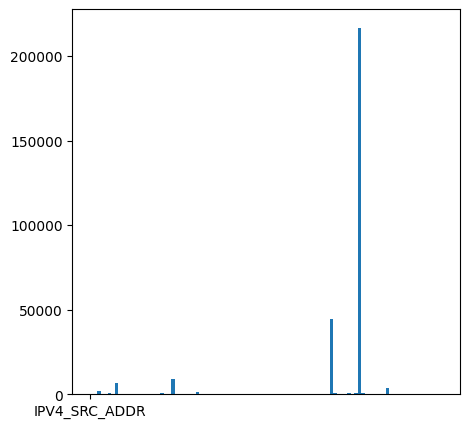

In [ ]:
# BoxPlot으로 확인
plt.figure(figsize=(5,5))
plt.hist([df['IPV4_SRC_ADDR']],100)
plt.xticks([1],['IPV4_SRC_ADDR'])

##PROTOCOL

#### IP protocol

6 : TCP

17 : UDP

1 : ICMP


In [ ]:
df['PROTOCOL'].value_counts()

6      184373
17     115386
1         157
2          23
58         11
89          4
47          3
150         1
130         1
214         1
65          1
228         1
206         1
15          1
135         1
114         1
180         1
217         1
183         1
98          1
94          1
143         1
53          1
199         1
236         1
251         1
248         1
99          1
90          1
37          1
253         1
234         1
91          1
77          1
154         1
250         1
167         1
126         1
225         1
177         1
237         1
191         1
216         1
205         1
166         1
22          1
211         1
194         1
40          1
13          1
Name: PROTOCOL, dtype: int64

##L7_PROTO

In [ ]:
#df['L7_PROTO'].astype('int').value_counts()
df['L7_PROTO'].value_counts()[0:20]

0.000      96098
188.000    72613
91.000      7298
5.126       5416
1.000       2496
41.000      2094
91.178      1742
91.126      1638
7.178       1473
5.178       1240
92.000       874
5.119        771
5.240        663
77.000       648
7.126        598
131.700      588
5.239        454
5.212        412
3.000        370
4.000        317
131.000      285
88.000       279
91.212       278
5.120        262
91.119       233
91.220       228
91.239       227
5.233        185
91.240       133
5.000        121
89.000       102
91.120       101
10.000        98
2.000         96
5.124         88
91.140        80
114.000       69
20.000        67
Name: L7_PROTO, dtype: int64

([<matplotlib.axis.XTick at 0x788e2a866dd0>], [Text(1, 0, 'L7_PROTO')])

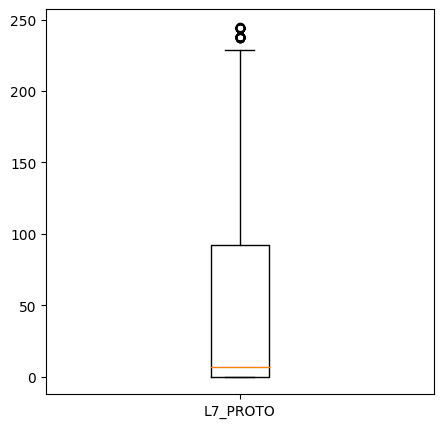

In [ ]:
# BoxPlot으로 확인
plt.figure(figsize=(5,5))
plt.boxplot([df['L7_PROTO']])
plt.xticks([1],['L7_PROTO'])


##IN_BYTES

In [ ]:
df['IN_BYTES'].value_counts()[0:20]

56     54644
280    49886
44     27346
84     10934
420    10852
48     10069
140     6923
112     5412
40      5039
68      4978
65      3679
164     2702
70      2417
320     2206
71      2142
180     2059
132     1903
63      1872
60      1723
67      1720
Name: IN_BYTES, dtype: int64

([<matplotlib.axis.XTick at 0x7d1ed1f00670>], [Text(1, 0, 'IN_BYTES')])

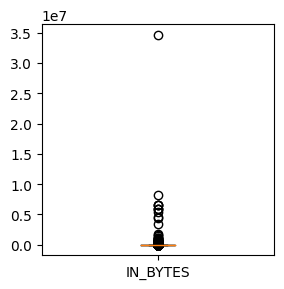

In [ ]:
# 랜덤으로 3개 Feature를 시각화하여 탐색한다.
# BoxPlot으로 확인
plt.figure(figsize=(3,3))
plt.boxplot([df['IN_BYTES']])
plt.xticks([1],['IN_BYTES'])

##TCP_FLAGS

In [ ]:
df['TCP_FLAGS'].value_counts()[0:20]

0      115649
2       83744
22      28407
27      22671
219      9402
30       7470
223      6903
222      6419
19       4994
18       3054
31       2949
24       1945
23       1908
16       1364
20        732
17        611
25        402
26        347
214       295
211       251
Name: TCP_FLAGS, dtype: int64

##ICMP_TYPE

ICMP Type * 256 + ICMP code

ICMP_TYPE 이 0 이 아니지만 ICMP가 아니고 TCP 인 레코드 존재



In [ ]:
(df_orig['ICMP_TYPE'] & 0xff00).value_counts()[0:20]

0        267071
35840     18679
49920      2102
6912        836
6144        747
16896       578
8960        568
11008       488
62976       424
52480       375
13056       371
33792       267
64000       249
48640       216
44544       205
32000       203
31232       198
18944       196
10496       195
39936       193
Name: ICMP_TYPE, dtype: int64

<Axes: >

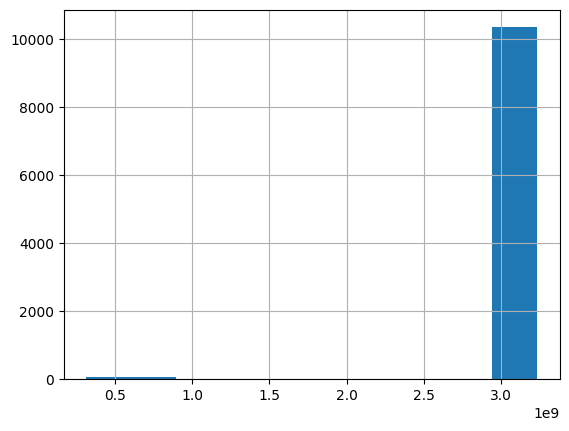

In [ ]:
attack_ip  = df[(df['IPV4_SRC_ADDR'] == 3232235808) & (df['Label'] == 1) ]['IPV4_DST_ADDR']
attack_ip.hist()

In [ ]:
#(df['ICMP_TYPE'] & 0xff).value_counts()[0:20]
#df['ICMP_CODE'] = df['ICMP_TYPE'] & 0xff
#df[(df['ICMP_TYPE'] != 0) &  (df['PROTOCOL'] !=  1)]
#df.groupby('sex').agg({'total_bill': 'mean',
df_orig[(df_orig['Attack'] == 'scanning') & (df['PROTOCOL'] != 6) ]

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,...,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack,Dataset
1102,3232235808,44514,3232235777,53,17,0.0,72,1,0,0,...,0,0,0,44596,12,0,0.0,1,scanning,NF-ToN-IoT-v2
8424,3232235808,59764,3232235777,53,17,0.0,72,1,108,1,...,0,0,0,50441,12,0,0.0,1,scanning,NF-ToN-IoT-v2
15816,3232235808,38386,3232235777,53,17,0.0,50,1,50,1,...,0,0,0,20161,28,0,0.0,1,scanning,NF-ToN-IoT-v2
56152,3232235808,48849,3232235777,53,17,0.0,72,1,0,0,...,0,0,0,22563,12,0,0.0,1,scanning,NF-ToN-IoT-v2
78786,3232235808,43673,3232235777,53,17,0.0,72,1,0,0,...,0,0,0,64550,12,0,0.0,1,scanning,NF-ToN-IoT-v2
85595,3232235808,33254,3232235777,53,17,0.0,70,1,252,1,...,0,0,0,61543,28,60,0.0,1,scanning,NF-ToN-IoT-v2
109503,3232235808,33123,3232235777,53,17,0.0,70,1,228,1,...,0,0,0,20489,1,60,0.0,1,scanning,NF-ToN-IoT-v2
123234,3232235807,500,3232235970,500,17,79.0,1932,2,0,0,...,0,0,0,0,0,0,0.0,1,scanning,NF-ToN-IoT-v2
141986,3232235808,52142,3232235777,53,17,0.0,50,1,50,1,...,0,0,0,41728,1,0,0.0,1,scanning,NF-ToN-IoT-v2
151306,3232235806,42983,3232235945,7010,17,0.0,64,2,0,0,...,0,0,0,0,0,0,0.0,1,scanning,NF-ToN-IoT-v2


In [ ]:
df['ICMP_TYPE'].value_counts()[0:20]

KeyError: ignored

##ICMP_IPV4_TYPE

In [ ]:
df['ICMP_IPV4_TYPE'].value_counts()[0:20]

0      267071
140     18679
195      2102
27        836
24        747
66        578
35        568
43        488
246       424
205       375
51        371
132       267
250       249
190       216
174       205
125       203
122       198
74        196
41        195
156       193
Name: ICMP_IPV4_TYPE, dtype: int64

##DNS_QUERY_ID

DNS query transaction Id

In [ ]:
df['DNS_QUERY_ID'].value_counts()[0:20]

0        258734
53421        52
10104        13
38007         7
41824         6
13551         5
50964         5
46340         5
42450         5
12921         5
37316         5
9914          5
57461         5
46455         5
6505          5
24898         5
44940         5
7671          5
18550         5
21369         5
Name: DNS_QUERY_ID, dtype: int64

##DNS_QUERY_TYPE

DNS query type (e.g. 1=A, 2=NS..)

In [ ]:
df['DNS_QUERY_TYPE'].value_counts()[0:20]

0      258734
1       30130
28      10319
12        365
255       335
43         74
2          29
16          7
48          6
33          1
Name: DNS_QUERY_TYPE, dtype: int64

##DNS_TTL_ANSWER


In [ ]:
df['DNS_TTL_ANSWER'].value_counts()[0:20]

0         264304
60         20299
20          1560
59           685
30           586
5            389
604800       379
19           372
1            318
18           285
15           254
17           249
16           242
3            241
10           219
40           217
2            213
12           211
14           209
9            203
Name: DNS_TTL_ANSWER, dtype: int64

##FTP_COMMAND_RET_CODE

In [ ]:
df['FTP_COMMAND_RET_CODE'].value_counts()

0.0      298082
125.0       495
229.0       494
230.0       353
331.0       259
221.0       185
530.0       108
227.0        13
150.0         4
213.0         2
220.0         2
200.0         1
550.0         1
257.0         1
Name: FTP_COMMAND_RET_CODE, dtype: int64

In [ ]:
#(df['ICMP_TYPE'] & 0xff).value_counts()[0:20]
#df['ICMP_CODE'] = df['ICMP_TYPE'] & 0xff
df['Label'].value_counts()

1    200921
0     99079
Name: Label, dtype: int64

In [ ]:
df['Attack'].value_counts()

Benign            99079
DDoS              86249
DoS               70576
scanning          14952
Reconnaissance    10344
xss                9546
password           4575
injection          2715
Bot                 561
Brute Force         500
Infilteration       482
Exploits            120
Fuzzers              87
Backdoor             87
Generic              59
mitm                 29
ransomware           17
Analysis              8
Shellcode             8
Theft                 5
Worms                 1
Name: Attack, dtype: int64

## 정량적 feature의 분포표 작성

Drop 컬럼 목록

|Featuer|배제사유|
|:---|:---|
|IPV4_SRC_ADDR|IP를 측도로 넣으려면 One hot encoding 해야 함|
|L4_SRC_PORT|Port를 측도로 넣으려면 One hot encoding 해야 함|
|IPV4_DST_ADDR|IP를 측도로 넣으려면 One hot encoding 해야 함|
|L4_DST_PORT|Port를 측도로 넣으려면 One hot encoding 해야 함|
|PROTOCOL|Protocol을 측도로 넣으려면 One hot encoding 해야 함|
|L7_PROTO|값의 의미를 모르겠음|
|DNS_QUERY_ID|Transaction ID는 공격 지표로서 의미가 없음|
|Label||
|Attack||
|Dataset||


Error in callback <function _draw_all_if_interactive at 0x788f577c11b0> (for post_execute):


KeyboardInterrupt: ignored

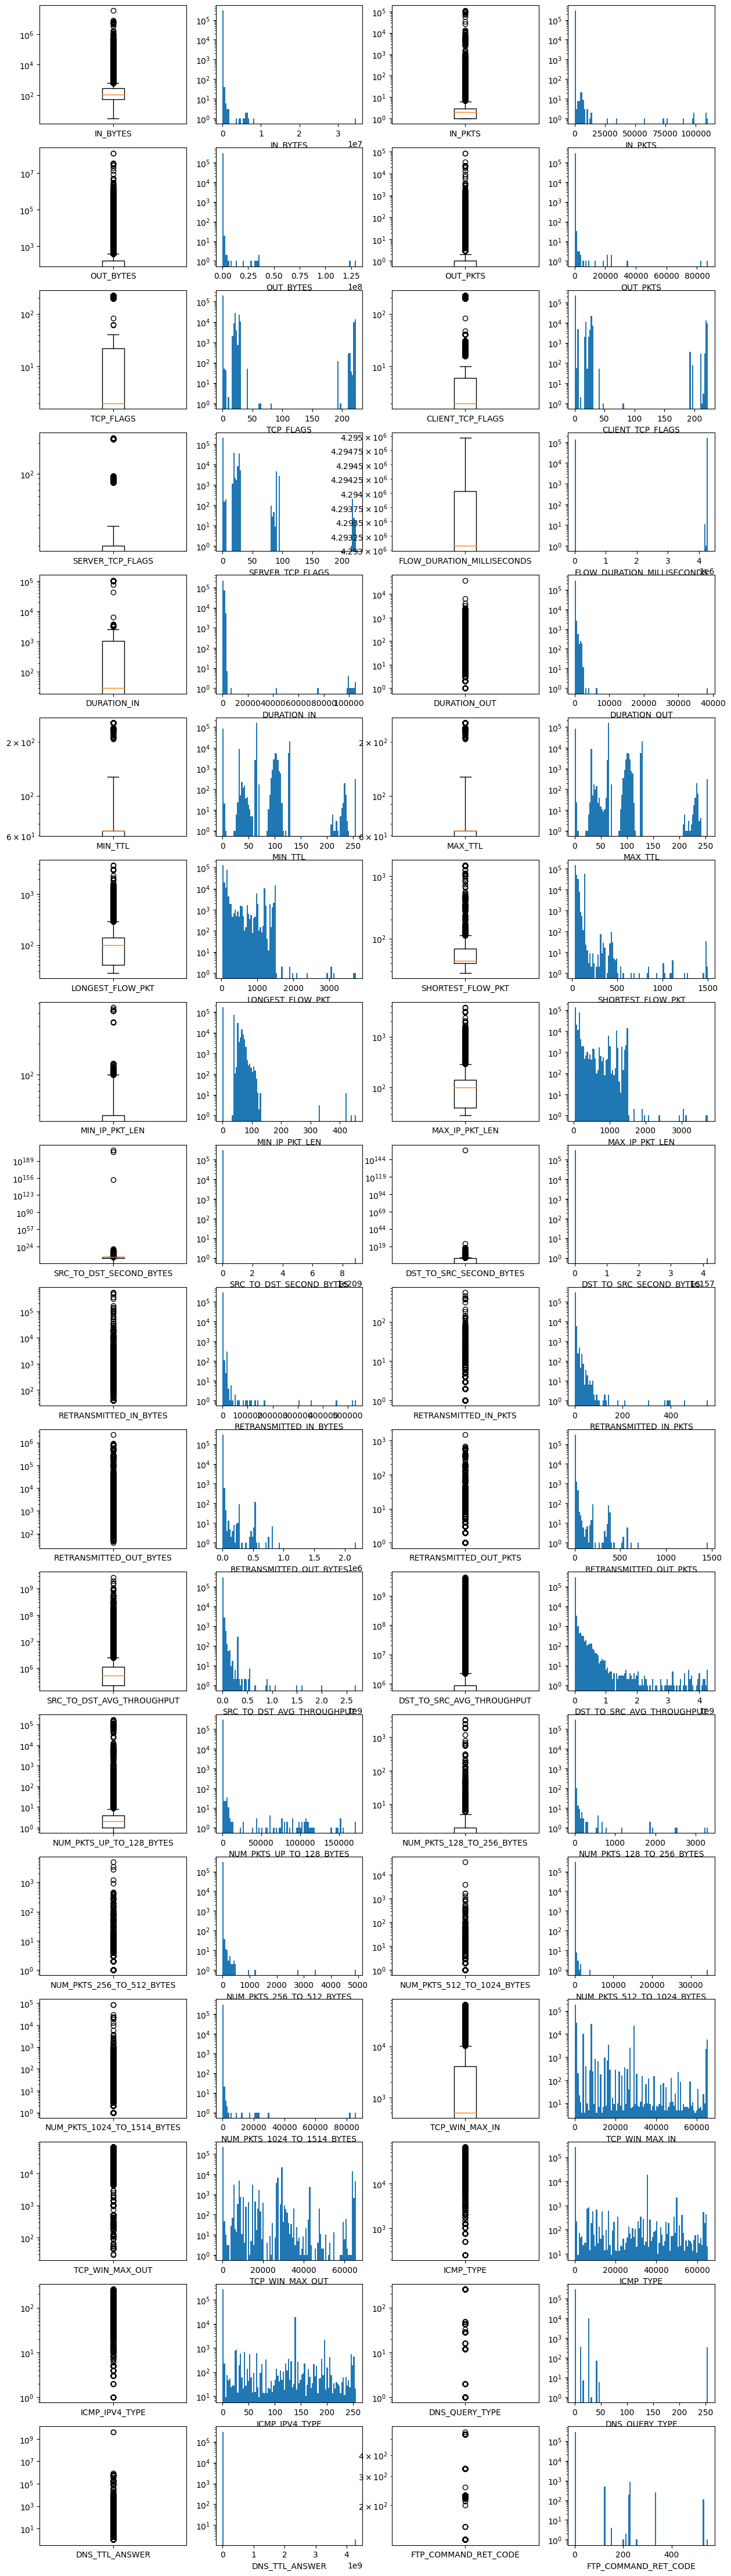

In [ ]:
#'IPV4_SRC_ADDR','L4_SRC_PORT','IPV4_DST_ADDR','L4_DST_PORT','PROTOCOL','L7_PROTO','IN_BYTES','IN_PKTS','OUT_BYTES','OUT_PKTS','TCP_FLAGS','CLIENT_TCP_FLAGS','SERVER_TCP_FLAGS','FLOW_DURATION_MILLISECONDS','DURATION_IN','DURATION_OUT','MIN_TTL','MAX_TTL','LONGEST_FLOW_PKT','SHORTEST_FLOW_PKT','MIN_IP_PKT_LEN','MAX_IP_PKT_LEN','SRC_TO_DST_SECOND_BYTES','DST_TO_SRC_SECOND_BYTES','RETRANSMITTED_IN_BYTES','RETRANSMITTED_IN_PKTS','RETRANSMITTED_OUT_BYTES','RETRANSMITTED_OUT_PKTS','SRC_TO_DST_AVG_THROUGHPUT','DST_TO_SRC_AVG_THROUGHPUT','NUM_PKTS_UP_TO_128_BYTES','NUM_PKTS_128_TO_256_BYTES','NUM_PKTS_256_TO_512_BYTES','NUM_PKTS_512_TO_1024_BYTES','NUM_PKTS_1024_TO_1514_BYTES','TCP_WIN_MAX_IN','TCP_WIN_MAX_OUT','ICMP_TYPE','ICMP_IPV4_TYPE','DNS_QUERY_ID','DNS_QUERY_TYPE','DNS_TTL_ANSWER','FTP_COMMAND_RET_CODE','Label','Attack','Dataset'
#'ICMP_TYPE','ICMP_IPV4_TYPE','DNS_QUERY_ID','DNS_QUERY_TYPE','DNS_TTL_ANSWER','FTP_COMMAND_RET_CODE','Label','Attack','Dataset'
cols = df.columns.drop(['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'DNS_QUERY_ID','Label','Attack','Dataset'])  #명목형변수, 레이블 변수 제외


plt.figure(figsize=(15,60))
k = 1
for col in cols:
  plt.subplot(19, 4, k) # 3행 3열의 9개의 그래프 중 (i+1)번째로 state 이동
  plt.boxplot([df[col]])
  plt.yscale('log')
  plt.xticks([1],[col])
  k = k+1
  plt.subplot(19, 4, k) # 3행 3열의 9개의 그래프 중 (i+1)번째로 state 이동
  plt.hist([df[col]],bins=100)
  plt.yscale('log')
  plt.xlabel(col)
  k = k+1

# Feature Normalization

# 컬럼 확장

# 인접 데이터 활용 학습 모델


0 group

 0   IPV4_SRC_ADDR                300000 non-null  object
 1   L4_SRC_PORT                  300000 non-null  int64  
 2   IPV4_DST_ADDR                300000 non-null  object
 3   L4_DST_PORT                  300000 non-null  int64  
 4   PROTOCOL                     300000 non-null  int64  
 5   L7_PROTO                     300000 non-null  float64
 6   IN_BYTES                     300000 non-null  int64  
 7   IN_PKTS                      300000 non-null  int64  
 8   OUT_BYTES                    300000 non-null  int64  
 9   OUT_PKTS                     300000 non-null  int64  
 10  TCP_FLAGS                    300000 non-null  int64  
 11  CLIENT_TCP_FLAGS             300000 non-null  int64  
 12  SERVER_TCP_FLAGS             300000 non-null  int64  
 13  FLOW_DURATION_MILLISECONDS   300000 non-null  int64  
 14  DURATION_IN                  300000 non-null  int64  
 15  DURATION_OUT                 300000 non-null  int64  
 16  MIN_TTL                      300000 non-null  int64  
 17  MAX_TTL                      300000 non-null  int64  
 18  LONGEST_FLOW_PKT             300000 non-null  int64  
 19  SHORTEST_FLOW_PKT            300000 non-null  int64  
 20  MIN_IP_PKT_LEN               300000 non-null  int64  
 21  MAX_IP_PKT_LEN               300000 non-null  int64  
 22  SRC_TO_DST_SECOND_BYTES      300000 non-null  float64
 23  DST_TO_SRC_SECOND_BYTES      300000 non-null  float64
 24  RETRANSMITTED_IN_BYTES       300000 non-null  int64  
 25  RETRANSMITTED_IN_PKTS        300000 non-null  int64  
 26  RETRANSMITTED_OUT_BYTES      300000 non-null  int64  
 27  RETRANSMITTED_OUT_PKTS       300000 non-null  int64  
 28  SRC_TO_DST_AVG_THROUGHPUT    300000 non-null  int64  
 29  DST_TO_SRC_AVG_THROUGHPUT    300000 non-null  int64  
 30  NUM_PKTS_UP_TO_128_BYTES     300000 non-null  int64  
 31  NUM_PKTS_128_TO_256_BYTES    300000 non-null  int64  
 32  NUM_PKTS_256_TO_512_BYTES    300000 non-null  int64  
 33  NUM_PKTS_512_TO_1024_BYTES   300000 non-null  int64  
 34  NUM_PKTS_1024_TO_1514_BYTES  300000 non-null  int64  
 35  TCP_WIN_MAX_IN               300000 non-null  int64  
 36  TCP_WIN_MAX_OUT              300000 non-null  int64  
 37  ICMP_TYPE                    300000 non-null  int64  
 38  ICMP_IPV4_TYPE               300000 non-null  int64  
 39  DNS_QUERY_ID                 300000 non-null  int64  
 40  DNS_QUERY_TYPE               300000 non-null  int64  
 41  DNS_TTL_ANSWER               300000 non-null  int64  
 42  FTP_COMMAND_RET_CODE         300000 non-null  float64
 43  Label                        300000 non-null  int64  
 44  Attack                       300000 non-null  object
 45  Dataset                      300000 non-null  object


1 group

현재 레코드 는 그대로 유지
  0   IPV4_SRC_ADDR                300000 non-null  object
 1   L4_SRC_PORT                  300000 non-null  int64  
 2   IPV4_DST_ADDR                300000 non-null  object
 3   L4_DST_PORT                  300000 non-null  int64  
 4   PROTOCOL                     300000 non-null  int64  
 5   L7_PROTO                     300000 non-null  float64
 6   IN_BYTES                     300000 non-null  int64  
 7   IN_PKTS                      300000 non-null  int64  
 8   OUT_BYTES                    300000 non-null  int64  
 9   OUT_PKTS                     300000 non-null  int64  
 10  TCP_FLAGS                    300000 non-null  int64  
 11  CLIENT_TCP_FLAGS             300000 non-null  int64  
 12  SERVER_TCP_FLAGS             300000 non-null  int64  
 13  FLOW_DURATION_MILLISECONDS   300000 non-null  int64  
 14  DURATION_IN                  300000 non-null  int64  
 15  DURATION_OUT                 300000 non-null  int64  
 16  MIN_TTL                      300000 non-null  int64  
 17  MAX_TTL                      300000 non-null  int64  
 18  LONGEST_FLOW_PKT             300000 non-null  int64  
 19  SHORTEST_FLOW_PKT            300000 non-null  int64  
 20  MIN_IP_PKT_LEN               300000 non-null  int64  
 21  MAX_IP_PKT_LEN               300000 non-null  int64  
 22  SRC_TO_DST_SECOND_BYTES      300000 non-null  float64
 23  DST_TO_SRC_SECOND_BYTES      300000 non-null  float64
 24  RETRANSMITTED_IN_BYTES       300000 non-null  int64  
 25  RETRANSMITTED_IN_PKTS        300000 non-null  int64  
 26  RETRANSMITTED_OUT_BYTES      300000 non-null  int64  
 27  RETRANSMITTED_OUT_PKTS       300000 non-null  int64  
 28  SRC_TO_DST_AVG_THROUGHPUT    300000 non-null  int64  
 29  DST_TO_SRC_AVG_THROUGHPUT    300000 non-null  int64  
 30  NUM_PKTS_UP_TO_128_BYTES     300000 non-null  int64  
 31  NUM_PKTS_128_TO_256_BYTES    300000 non-null  int64  
 32  NUM_PKTS_256_TO_512_BYTES    300000 non-null  int64  
 33  NUM_PKTS_512_TO_1024_BYTES   300000 non-null  int64  
 34  NUM_PKTS_1024_TO_1514_BYTES  300000 non-null  int64  
 35  TCP_WIN_MAX_IN               300000 non-null  int64  
 36  TCP_WIN_MAX_OUT              300000 non-null  int64  
 37  ICMP_TYPE                    300000 non-null  int64  
 38  ICMP_IPV4_TYPE               300000 non-null  int64  
 39  DNS_QUERY_ID                 300000 non-null  int64  
 40  DNS_QUERY_TYPE               300000 non-null  int64  
 41  DNS_TTL_ANSWER               300000 non-null  int64  
 42  FTP_COMMAND_RET_CODE         300000 non-null  float64

 삭제 0   IPV4_SRC_ADDR                300000 non-null  object
 43   L4_SRC_PORT_1                  300000 non-null  int64  
 44   IPV4_DST_ADDR_1                300000 non-null  object
 45   L4_DST_PORT_1                  300000 non-null  int64  
 46   PROTOCOL_1                     300000 non-null  int64  
 47   L7_PROTO_1                     300000 non-null  float64
 48   IN_BYTES_1                     300000 non-null  int64  
 7   IN_PKTS                      300000 non-null  int64  
 8   OUT_BYTES                    300000 non-null  int64  
 9   OUT_PKTS                     300000 non-null  int64  
 10  TCP_FLAGS                    300000 non-null  int64  
 11  CLIENT_TCP_FLAGS             300000 non-null  int64  
 12  SERVER_TCP_FLAGS             300000 non-null  int64  
 13  FLOW_DURATION_MILLISECONDS   300000 non-null  int64  
 14  DURATION_IN                  300000 non-null  int64  
 15  DURATION_OUT                 300000 non-null  int64  
 16  MIN_TTL                      300000 non-null  int64  
 17  MAX_TTL                      300000 non-null  int64  
 18  LONGEST_FLOW_PKT             300000 non-null  int64  
 19  SHORTEST_FLOW_PKT            300000 non-null  int64  
 20  MIN_IP_PKT_LEN               300000 non-null  int64  
 21  MAX_IP_PKT_LEN               300000 non-null  int64  
 22  SRC_TO_DST_SECOND_BYTES      300000 non-null  float64
 23  DST_TO_SRC_SECOND_BYTES      300000 non-null  float64
 24  RETRANSMITTED_IN_BYTES       300000 non-null  int64  
 25  RETRANSMITTED_IN_PKTS        300000 non-null  int64  
 26  RETRANSMITTED_OUT_BYTES      300000 non-null  int64  
 27  RETRANSMITTED_OUT_PKTS       300000 non-null  int64  
 28  SRC_TO_DST_AVG_THROUGHPUT    300000 non-null  int64  
 29  DST_TO_SRC_AVG_THROUGHPUT    300000 non-null  int64  
 30  NUM_PKTS_UP_TO_128_BYTES     300000 non-null  int64  
 31  NUM_PKTS_128_TO_256_BYTES    300000 non-null  int64  
 32  NUM_PKTS_256_TO_512_BYTES    300000 non-null  int64  
 33  NUM_PKTS_512_TO_1024_BYTES   300000 non-null  int64  
 34  NUM_PKTS_1024_TO_1514_BYTES  300000 non-null  int64  
 35  TCP_WIN_MAX_IN               300000 non-null  int64  
 36  TCP_WIN_MAX_OUT              300000 non-null  int64  
 37  ICMP_TYPE                    300000 non-null  int64  
 38  ICMP_IPV4_TYPE               300000 non-null  int64  
 39  DNS_QUERY_ID                 300000 non-null  int64  
 81  DNS_QUERY_TYPE_1               300000 non-null  int64  
 82  DNS_TTL_ANSWER_1               300000 non-null  int64  
 83  FTP_COMMAND_RET_CODE_1         300000 non-null  float64


 2 group

 삭제   L4_SRC_PORT                  300000 non-null  int64  
 84   IPV4_DST_ADDR_2                300000 non-null  object
 85   L4_DST_PORT_2                  300000 non-null  int64  
 86   PROTOCOL_2                     300000 non-null  int64  
 5   L7_PROTO                     300000 non-null  float64
 6   IN_BYTES                     300000 non-null  int64  
 7   IN_PKTS                      300000 non-null  int64  
 8   OUT_BYTES                    300000 non-null  int64  
 9   OUT_PKTS                     300000 non-null  int64  
 10  TCP_FLAGS                    300000 non-null  int64  
 11  CLIENT_TCP_FLAGS             300000 non-null  int64  
 12  SERVER_TCP_FLAGS             300000 non-null  int64  
 13  FLOW_DURATION_MILLISECONDS   300000 non-null  int64  
 14  DURATION_IN                  300000 non-null  int64  
 15  DURATION_OUT                 300000 non-null  int64  
 16  MIN_TTL                      300000 non-null  int64  
 17  MAX_TTL                      300000 non-null  int64  
 18  LONGEST_FLOW_PKT             300000 non-null  int64  
 19  SHORTEST_FLOW_PKT            300000 non-null  int64  
 20  MIN_IP_PKT_LEN               300000 non-null  int64  
 21  MAX_IP_PKT_LEN               300000 non-null  int64  
 22  SRC_TO_DST_SECOND_BYTES      300000 non-null  float64
 23  DST_TO_SRC_SECOND_BYTES      300000 non-null  float64
 24  RETRANSMITTED_IN_BYTES       300000 non-null  int64  
 25  RETRANSMITTED_IN_PKTS        300000 non-null  int64  
 26  RETRANSMITTED_OUT_BYTES      300000 non-null  int64  
 27  RETRANSMITTED_OUT_PKTS       300000 non-null  int64  
 28  SRC_TO_DST_AVG_THROUGHPUT    300000 non-null  int64  
 29  DST_TO_SRC_AVG_THROUGHPUT    300000 non-null  int64  
 30  NUM_PKTS_UP_TO_128_BYTES     300000 non-null  int64  
 31  NUM_PKTS_128_TO_256_BYTES    300000 non-null  int64  
 32  NUM_PKTS_256_TO_512_BYTES    300000 non-null  int64  
 33  NUM_PKTS_512_TO_1024_BYTES   300000 non-null  int64  
 34  NUM_PKTS_1024_TO_1514_BYTES  300000 non-null  int64  
 35  TCP_WIN_MAX_IN               300000 non-null  int64  
 36  TCP_WIN_MAX_OUT              300000 non-null  int64  
 37  ICMP_TYPE                    300000 non-null  int64  
 38  ICMP_IPV4_TYPE               300000 non-null  int64  
 39  DNS_QUERY_ID                 300000 non-null  int64  
 40  DNS_QUERY_TYPE               300000 non-null  int64  
 41  DNS_TTL_ANSWER               300000 non-null  int64  
 124  FTP_COMMAND_RET_CODE_2         300000 non-null  float64
_
0 그룹은 현재의 레코드를 유지한다.     Y는 Attack의 dummy 변환값
1 그룹은 0그룹의 Src_IP와 동일한 레코드를 과거 가장가까운 시간 레코드를 찾아 그 값을 복사한다.
만약 과거 가장 가까운 시간 레코드가 존재하지 않으면 미래의 가장 가까운 시간 레코드를 찾아 그 값을 복사한다.
만약 과거도 미래도 없으면 모든 값을 0으로 설정한다.

2 그룹은 0그룹의 Src_IP와 동일한 레코드를 과거 두번째 가까운 시간 레코드를 찾아 그 값을 복사한다.
만약 두번째 가까운 레코드가 없으면 첫번째 가까운레코드가 있는경우는
 - 미래에 가장가까운 레코드를 찾아 그 값을 복사한다.

만약 과거 가장 가까운 시간 레코드가 존재하지 않으면 미래의 두번째 가까운 시간 레코드를 찾아 그 값을 복사한다.
 만약 그 값이 존재하지 않으면 모든 값을 0으로 설정한다.




In [ ]:
df[(df['PROTOCOL'] != 1) & (df['ICMP_TYPE'] != 0)]['ICMP_TYPE'] = 0


In [ ]:
x_columns = df.columns.drop('Attack')
x_columns = x_columns.drop('Dataset')
x_columns = x_columns.drop('Label')

#x = df[x_columns].values
x_Label = df[x_columns]


In [51]:
# Convert to numpy - Classification
df['IPV4_SRC_ADDR'] = df['IPV4_SRC_ADDR'].astype('int64')
df['IPV4_DST_ADDR'] = df['IPV4_DST_ADDR'].astype('int64')
df['L4_SRC_PORT'] = df['L4_SRC_PORT'].astype('float64')
df['L4_DST_PORT'] = df['L4_DST_PORT'].astype('float64')
df['PROTOCOL'] = df['PROTOCOL'].astype('float64')
df['IN_BYTES'] = df['IN_BYTES'].astype('float64')
df['IN_PKTS'] = df['IN_PKTS'].astype('float64')
df['OUT_BYTES'] = df['OUT_BYTES'].astype('float64')
df['OUT_PKTS'] = df['OUT_PKTS'].astype('float64')
df['TCP_FLAGS'] = df['TCP_FLAGS'].astype('float64')
df['CLIENT_TCP_FLAGS'] = df['CLIENT_TCP_FLAGS'].astype('float64')
df['SERVER_TCP_FLAGS'] = df['SERVER_TCP_FLAGS'].astype('float64')
df['FLOW_DURATION_MILLISECONDS'] = df['FLOW_DURATION_MILLISECONDS'].astype('float64')
df['DURATION_IN'] = df['DURATION_IN'].astype('float64')
df['DURATION_OUT'] = df['DURATION_OUT'].astype('float64')
df['SRC_TO_DST_SECOND_BYTES'] = df['SRC_TO_DST_SECOND_BYTES'].astype('float64')
df['DST_TO_SRC_SECOND_BYTES'] = df['DST_TO_SRC_SECOND_BYTES'].astype('float64')

df['MIN_TTL'] = df['MIN_TTL'].astype('float64')
df['MAX_TTL'] = df['MAX_TTL'].astype('float64')
df['LONGEST_FLOW_PKT'] = df['LONGEST_FLOW_PKT'].astype('float64')
df['SHORTEST_FLOW_PKT'] = df['SHORTEST_FLOW_PKT'].astype('float64')
df['MIN_IP_PKT_LEN'] = df['MIN_IP_PKT_LEN'].astype('float64')
df['MAX_IP_PKT_LEN'] = df['MAX_IP_PKT_LEN'].astype('float64')
df['RETRANSMITTED_IN_BYTES'] = df['RETRANSMITTED_IN_BYTES'].astype('float64')
df['RETRANSMITTED_IN_PKTS'] = df['RETRANSMITTED_IN_PKTS'].astype('float64')
df['RETRANSMITTED_OUT_BYTES'] = df['RETRANSMITTED_OUT_BYTES'].astype('float64')
df['RETRANSMITTED_OUT_PKTS'] = df['RETRANSMITTED_OUT_PKTS'].astype('float64')
df['SRC_TO_DST_AVG_THROUGHPUT'] = df['SRC_TO_DST_AVG_THROUGHPUT'].astype('float64')
df['DST_TO_SRC_AVG_THROUGHPUT'] = df['DST_TO_SRC_AVG_THROUGHPUT'].astype('float64')
df['NUM_PKTS_UP_TO_128_BYTES'] = df['NUM_PKTS_UP_TO_128_BYTES'].astype('float64')
df['NUM_PKTS_128_TO_256_BYTES'] = df['NUM_PKTS_128_TO_256_BYTES'].astype('float64')
df['NUM_PKTS_256_TO_512_BYTES'] = df['NUM_PKTS_256_TO_512_BYTES'].astype('float64')
df['NUM_PKTS_512_TO_1024_BYTES'] = df['NUM_PKTS_512_TO_1024_BYTES'].astype('float64')
df['NUM_PKTS_1024_TO_1514_BYTES'] = df['NUM_PKTS_1024_TO_1514_BYTES'].astype('float64')
df['TCP_WIN_MAX_IN'] = df['TCP_WIN_MAX_IN'].astype('float64')
df['TCP_WIN_MAX_OUT'] = df['TCP_WIN_MAX_OUT'].astype('float64')
df['ICMP_TYPE'] = df['ICMP_TYPE'].astype('float64')
df['ICMP_IPV4_TYPE'] = df['ICMP_IPV4_TYPE'].astype('float64')
df['DNS_QUERY_ID'] = df['DNS_QUERY_ID'].astype('float64')
df['DNS_QUERY_TYPE'] = df['DNS_QUERY_TYPE'].astype('float64')
df['DNS_TTL_ANSWER'] = df['DNS_TTL_ANSWER'].astype('float64')

x_columns = df.columns.drop('Attack')
x_columns = x_columns.drop('Dataset')
x_columns = x_columns.drop('Label')

#x = df[x_columns].values
x = df[x_columns]

In [43]:
df1 = pd.DataFrame([['A0', 'A1', 'A2', 'A3'],
                    ['B0', 'B1', 'B2', 'B3'],
                    ['C0', 'C1', 'C2', 'C3'],
                    ['D0', 'D1', 'D2', 'D3']], columns=list('ABCD'))

df2 = pd.DataFrame([['A4', 'A5', 'A6', 'A7'],
                    ['B4', 'B5', 'B6', 'B7'],
                    ['C4', 'C5', 'C6', 'C7'],
                    ['D4', 'D5', 'D6', 'D7']], columns=['A', 'B', 'C', 'D'])

df3 = pd.DataFrame([['A8', 'A9', 'A10', 'A11'],
                    ['B8', 'B9', 'B10', 'B11'],
                    ['C8', 'C9', 'C10', 'C11'],
                    ['D8', 'D9', 'D10', 'D11']], columns=list('ABCD'))
df2 = df2.add_suffix("_1")
df3 = df3.add_suffix("_2")

pd.concat([df1, df2, df3], axis=1)

,A,B,C,D,A_1,B_1,C_1,D_1,A_2,B_2,C_2,D_2
0,A0,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11
1,B0,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11
2,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11
3,D0,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11


In [ ]:
import pandas as pd

udf=pd.DataFrame([[11,21],[14,24],[12,22],[12,23],[12,20],[15,25]],

                         index=[0,1,2,3,4,5], columns=['N2','N1'])

sdf=udf.sort_values(by=['N2'])

print (udf)
print (sdf)

   N2  N1
0  11  21
1  14  24
2  12  22
3  12  23
4  12  20
5  15  25
   N2  N1
0  11  21
2  12  22
3  12  23
4  12  20
1  14  24
5  15  25


In [ ]:
df_ext = df.copy()
df_ext1 = df.copy()
df_ext2 = df.copy()
df_ext_sort2 = df.copy()
#df_ext1.add_suffix("_1")
#df_ext2.add_suffix("_2")

df_ext_sort = df_ext_sort2.sort_values(by=['IPV4_SRC_ADDR'], kind='mergesort')
df_ext_sort

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,...,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack,Dataset
176,0.000000e+00,51290.0,0.000000e+00,5355.0,17.0,0.0,162.0,2.0,0.0,0.0,...,0.0,0.0,0.0,14043.0,255.0,0.0,0.0,0,Benign,NF-CSE-CIC-IDS2018-v2
449,0.000000e+00,62789.0,0.000000e+00,5355.0,17.0,0.0,162.0,2.0,0.0,0.0,...,0.0,0.0,0.0,8693.0,255.0,0.0,0.0,0,Benign,NF-CSE-CIC-IDS2018-v2
4495,0.000000e+00,61662.0,0.000000e+00,5355.0,17.0,0.0,162.0,2.0,0.0,0.0,...,0.0,0.0,0.0,20688.0,255.0,0.0,0.0,0,Benign,NF-CSE-CIC-IDS2018-v2
4804,0.000000e+00,49154.0,0.000000e+00,5355.0,17.0,0.0,162.0,2.0,0.0,0.0,...,0.0,0.0,0.0,31209.0,255.0,0.0,0.0,0,Benign,NF-CSE-CIC-IDS2018-v2
5506,0.000000e+00,60679.0,0.000000e+00,5355.0,17.0,0.0,140.0,2.0,0.0,0.0,...,0.0,0.0,0.0,33213.0,1.0,0.0,0.0,0,Benign,NF-CSE-CIC-IDS2018-v2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286683,4.054638e+09,32787.0,3.232236e+09,80.0,6.0,7.0,40.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Benign,NF-ToN-IoT-v2
243504,4.089401e+09,42765.0,3.232236e+09,80.0,6.0,7.0,40.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Benign,NF-ToN-IoT-v2
252795,4.117052e+09,26252.0,3.232236e+09,80.0,6.0,7.0,40.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Benign,NF-ToN-IoT-v2
36844,4.139870e+09,22947.0,3.232236e+09,80.0,6.0,7.0,40.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Benign,NF-ToN-IoT-v2


In [47]:
index

Int64Index([   176,    449,   4495,   4804,   5506,   6772,   9773,   9822,
             10696,  11036,
            ...
            137513, 234941, 116080, 154802,  62397, 286683, 243504, 252795,
             36844,  55697],
           dtype='int64', length=300000)

In [ ]:
df_ext_sort2 = df.copy()

df_ext_sort = df_ext_sort2.sort_values(by=['IPV4_SRC_ADDR'], kind='mergesort')

df_ext = df_ext_sort.copy()
df_ext1 = df_ext_sort.copy()
df_ext2 = df_ext_sort.copy()

#df_ext1.add_suffix("_1")
#df_ext2.add_suffix("_2")


index = df_ext.index

cols = df_ext.columns;
myarr = np.zeros((1,46))
zero_df = pd.DataFrame(myarr, columns=cols)

size =  index.size

for i in range(index.size):
  if i%1000 == 0:
    print(i)

  src_addr = df_ext.loc[index[i]]['IPV4_SRC_ADDR']

  if (i > 0) and (df_ext.loc[index[i-1]]['IPV4_SRC_ADDR'] == src_addr) :
    df_ext1.loc[index[i]] = df_ext.loc[index[i-1]]
    if (i > 1) and (df_ext.loc[index[i-2]]['IPV4_SRC_ADDR'] == src_addr):
      df_ext2.loc[index[i]] = df_ext.loc[index[i-2]]
    else:
      if (i < (size-1)) and (df_ext.loc[index[i+1]]['IPV4_SRC_ADDR'] == src_addr):
        df_ext2.loc[index[i]] = df_ext.loc[index[i+1]]
      else:
        df_ext2.loc[index[i]] = zero_df.loc[0]
  else:
    if(i < (size-1)) and (df_ext.loc[index[i+1]]['IPV4_SRC_ADDR'] == src_addr):
      df_ext1.loc[index[i]] = df_ext.loc[index[i+1]]
      if (i < (size-2)) and (df_ext.loc[index[i+2]]['IPV4_SRC_ADDR'] == src_addr):
        df_ext2.loc[index[i]] = df_ext.loc[index[i+2]]
      else:
        df_ext2.loc[index[i]] = zero_df.loc[0]
    else:
      df_ext1.loc[index[i]] = zero_df.loc[0]
      df_ext2.loc[index[i]] = zero_df.loc[0]


df_ext1 = df_ext1.add_suffix("_1")
df_ext2 = df_ext2.add_suffix("_2")

df_extend = pd.concat([df_ext, df_ext1, df_ext2], axis=1)

df_extend.to_csv(colab_path + "NF-UQ-NIDS-v2_300K_extend.csv")


In [58]:
df_extend.to_csv(colab_path + "NF-UQ-NIDS-v2_300K_extend.csv")

In [46]:
df_ext1

,IPV4_SRC_ADDR_1,L4_SRC_PORT_1,IPV4_DST_ADDR_1,L4_DST_PORT_1,PROTOCOL_1,L7_PROTO_1,IN_BYTES_1,IN_PKTS_1,OUT_BYTES_1,OUT_PKTS_1,...,TCP_WIN_MAX_OUT_1,ICMP_TYPE_1,ICMP_IPV4_TYPE_1,DNS_QUERY_ID_1,DNS_QUERY_TYPE_1,DNS_TTL_ANSWER_1,FTP_COMMAND_RET_CODE_1,Label_1,Attack_1,Dataset_1
176,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
449,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
4495,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
4804,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
5506,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286683,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
243504,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
252795,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
36844,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0


In [45]:
df_ext

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,...,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack,Dataset
176,0,51290.0,0,5355.0,17.0,0.0,162.0,2.0,0.0,0.0,...,0.0,0.0,0.0,14043.0,255.0,0.0,0.0,0,Benign,NF-CSE-CIC-IDS2018-v2
449,0,62789.0,0,5355.0,17.0,0.0,162.0,2.0,0.0,0.0,...,0.0,0.0,0.0,8693.0,255.0,0.0,0.0,0,Benign,NF-CSE-CIC-IDS2018-v2
4495,0,61662.0,0,5355.0,17.0,0.0,162.0,2.0,0.0,0.0,...,0.0,0.0,0.0,20688.0,255.0,0.0,0.0,0,Benign,NF-CSE-CIC-IDS2018-v2
4804,0,49154.0,0,5355.0,17.0,0.0,162.0,2.0,0.0,0.0,...,0.0,0.0,0.0,31209.0,255.0,0.0,0.0,0,Benign,NF-CSE-CIC-IDS2018-v2
5506,0,60679.0,0,5355.0,17.0,0.0,140.0,2.0,0.0,0.0,...,0.0,0.0,0.0,33213.0,1.0,0.0,0.0,0,Benign,NF-CSE-CIC-IDS2018-v2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286683,4054637786,32787.0,3232235970,80.0,6.0,7.0,40.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Benign,NF-ToN-IoT-v2
243504,4089400905,42765.0,3232235970,80.0,6.0,7.0,40.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Benign,NF-ToN-IoT-v2
252795,4117051524,26252.0,3232235928,80.0,6.0,7.0,40.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Benign,NF-ToN-IoT-v2
36844,4139869894,22947.0,3232235970,80.0,6.0,7.0,40.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Benign,NF-ToN-IoT-v2


In [56]:
#전처리된 데이터 로드
#f_orig = pd.read_csv(colab_path + 'data_processed/kdd_processed.csv')
df_orig = pd.read_csv(colab_path+"NF-UQ-NIDS-v2_300K_extend1.csv",index_col=0, nrows=300000)
df = df_orig.copy()

In [59]:
df.columns

Index(['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT',
       'PROTOCOL', 'L7_PROTO', 'IN_BYTES', 'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS',
       ...
       'TCP_WIN_MAX_OUT_2', 'ICMP_TYPE_2', 'ICMP_IPV4_TYPE_2',
       'DNS_QUERY_ID_2', 'DNS_QUERY_TYPE_2', 'DNS_TTL_ANSWER_2',
       'FTP_COMMAND_RET_CODE_2', 'Label_2', 'Attack_2', 'Dataset_2'],
      dtype='object', length=138)

In [34]:
print(df_ext_sort['IPV4_SRC_ADDR'].astype('int64'))

Id
0         3232261268
1         3232261268
2         3232235807
3         3232235810
4         3232235806
             ...    
299995    3232261269
299996    3232261269
299997    3232235810
299998    3285401291
299999    3232261268
Name: IPV4_SRC_ADDR, Length: 300000, dtype: int64


In [ ]:
df = df.sort_index(kind='mergesort')
df

In [63]:
dummies = pd.get_dummies(df['Attack']) # Classification
dummiesLabel = pd.get_dummies(df['Label']) # Classification
y_1_label = df['Label'].values

outcomes = dummies.columns
num_classes = len(outcomes)
y = dummies.values
y_label = dummiesLabel.values

In [64]:
y
y_1_label

array([1, 1, 0, ..., 1, 0, 1])

In [65]:
y.shape
y_label.shape

(300000, 2)

In [66]:
dummies.columns

Index(['Analysis', 'Backdoor', 'Benign', 'Bot', 'Brute Force', 'DDoS', 'DoS',
       'Exploits', 'Fuzzers', 'Generic', 'Infilteration', 'Reconnaissance',
       'Shellcode', 'Theft', 'Worms', 'injection', 'mitm', 'password',
       'ransomware', 'scanning', 'xss'],
      dtype='object')

# Data와 Label의 분리

In [67]:
# 확장판에서 사용
#cols = df.columns.drop(['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'DNS_QUERY_ID','Label','Attack','Dataset'])  #명목형변수, 레이블 변수 제외
cols = df.columns.drop(['Label','Attack','Dataset', 'Label_1','Attack_1','Dataset_1', 'Label_2','Attack_2','Dataset_2'])  #명목형변수, 레이블 변수 제외
#cols = df.columns.drop(['Attack','Dataset'])  #명목형변수, 레이블 변수 제외
X = df[cols]
dummies = pd.get_dummies(df['Attack']) # Classification
outcomes = dummies.columns
num_classes = len(outcomes)
Y = dummies.values
#X.shape

In [ ]:
#cols = df.columns.drop(['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'PROTOCOL', 'L7_PROTO', 'DNS_QUERY_ID','Label','Attack','Dataset'])  #명목형변수, 레이블 변수 제외
cols = df.columns.drop(['Label','Attack','Dataset'])  #명목형변수, 레이블 변수 제외
#cols = df.columns.drop(['Attack','Dataset'])  #명목형변수, 레이블 변수 제외
X = df[cols]
dummies = pd.get_dummies(df['Attack']) # Classification
outcomes = dummies.columns
num_classes = len(outcomes)
Y = dummies.values
#X.shape

In [68]:
def max_8G(val):
    if (val > 1.0e+9): return 1.0e+9
    return val
X = X.applymap(max_8G)

In [69]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 0 to 299999
Columns: 129 entries, IPV4_SRC_ADDR to FTP_COMMAND_RET_CODE_2
dtypes: float64(129)
memory usage: 297.5 MB


In [70]:
#X['SRC_TO_DST_SECOND_BYTES'].value_counts()[0:20]
df['SRC_TO_DST_SECOND_BYTES'].max()
df['DST_TO_SRC_SECOND_BYTES'].max()


4.1600406642007256e+157

In [71]:
X.isnull().sum()

IPV4_SRC_ADDR             0
L4_SRC_PORT               0
IPV4_DST_ADDR             0
L4_DST_PORT               0
PROTOCOL                  0
                         ..
ICMP_IPV4_TYPE_2          0
DNS_QUERY_ID_2            0
DNS_QUERY_TYPE_2          0
DNS_TTL_ANSWER_2          0
FTP_COMMAND_RET_CODE_2    0
Length: 129, dtype: int64

#전처리 및 정규화

#Z-Score 정규화 진행

정규분포 mapping

In [72]:
# 데이터 정규화
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV


#scaler_train_minmax = preprocessing.MinMaxScaler()

scaler_train = preprocessing.StandardScaler()
#scaler_train = preprocessing.MinMaxScaler()
scaler_train = scaler_train.fit(X)
X = pd.DataFrame(scaler_train.transform(X),index=np.arange(0,300000,1), columns = X.columns)
#X = scaler_train.transform(X)


In [73]:
X.info

<bound method DataFrame.info of         IPV4_SRC_ADDR  L4_SRC_PORT  IPV4_DST_ADDR  L4_DST_PORT  PROTOCOL  \
0            0.196438     1.355112       0.132727    -0.305304 -0.745103   
1            0.196438    -1.589191       0.132727    -0.305304 -0.745103   
2            0.196438     0.088739       0.132727    -0.215349 -0.745103   
3            0.196438     0.348615       0.132727     0.539954 -0.745103   
4            0.196438     0.539220       0.132727    -0.211324 -0.745103   
...               ...          ...            ...          ...       ...   
299995       0.196438     0.532162       0.132727    -0.305304  1.182231   
299996       0.196438    -0.018806       0.132727    -0.225552 -0.745103   
299997       0.196438     0.637481       0.132727    -0.305304 -0.745103   
299998       0.196438     1.183617       0.132727    -0.271138 -0.745103   
299999       0.196438    -1.247069       0.132727    -0.305304  1.182231   

        L7_PROTO  IN_BYTES   IN_PKTS  OUT_BYTES  OUT_PK

###3 Sigma maxmum 처리

In [77]:
def max_3sigma(val):
    if (val < -3): return -3
    if (val > 3): return 3
    return val


In [75]:
max_3sigma(-5)

-3

In [76]:
X.isnull().sum()

IPV4_SRC_ADDR             0
L4_SRC_PORT               0
IPV4_DST_ADDR             0
L4_DST_PORT               0
PROTOCOL                  0
                         ..
ICMP_IPV4_TYPE_2          0
DNS_QUERY_ID_2            0
DNS_QUERY_TYPE_2          0
DNS_TTL_ANSWER_2          0
FTP_COMMAND_RET_CODE_2    0
Length: 129, dtype: int64

In [78]:
X = X.applymap(max_3sigma)

In [79]:
#X.apply(max_3sigma, axis='index')
#X.apply(lambda x:3 if (x > 3) else x, axis=1)
X.max()
#X.min()


IPV4_SRC_ADDR             0.196438
L4_SRC_PORT               1.363038
IPV4_DST_ADDR             0.132727
L4_DST_PORT               3.000000
PROTOCOL                  3.000000
                            ...   
ICMP_IPV4_TYPE_2          3.000000
DNS_QUERY_ID_2            3.000000
DNS_QUERY_TYPE_2          3.000000
DNS_TTL_ANSWER_2          3.000000
FTP_COMMAND_RET_CODE_2    3.000000
Length: 129, dtype: float64

In [80]:
X['IN_BYTES'].max()

3.0

ValueError: ignored

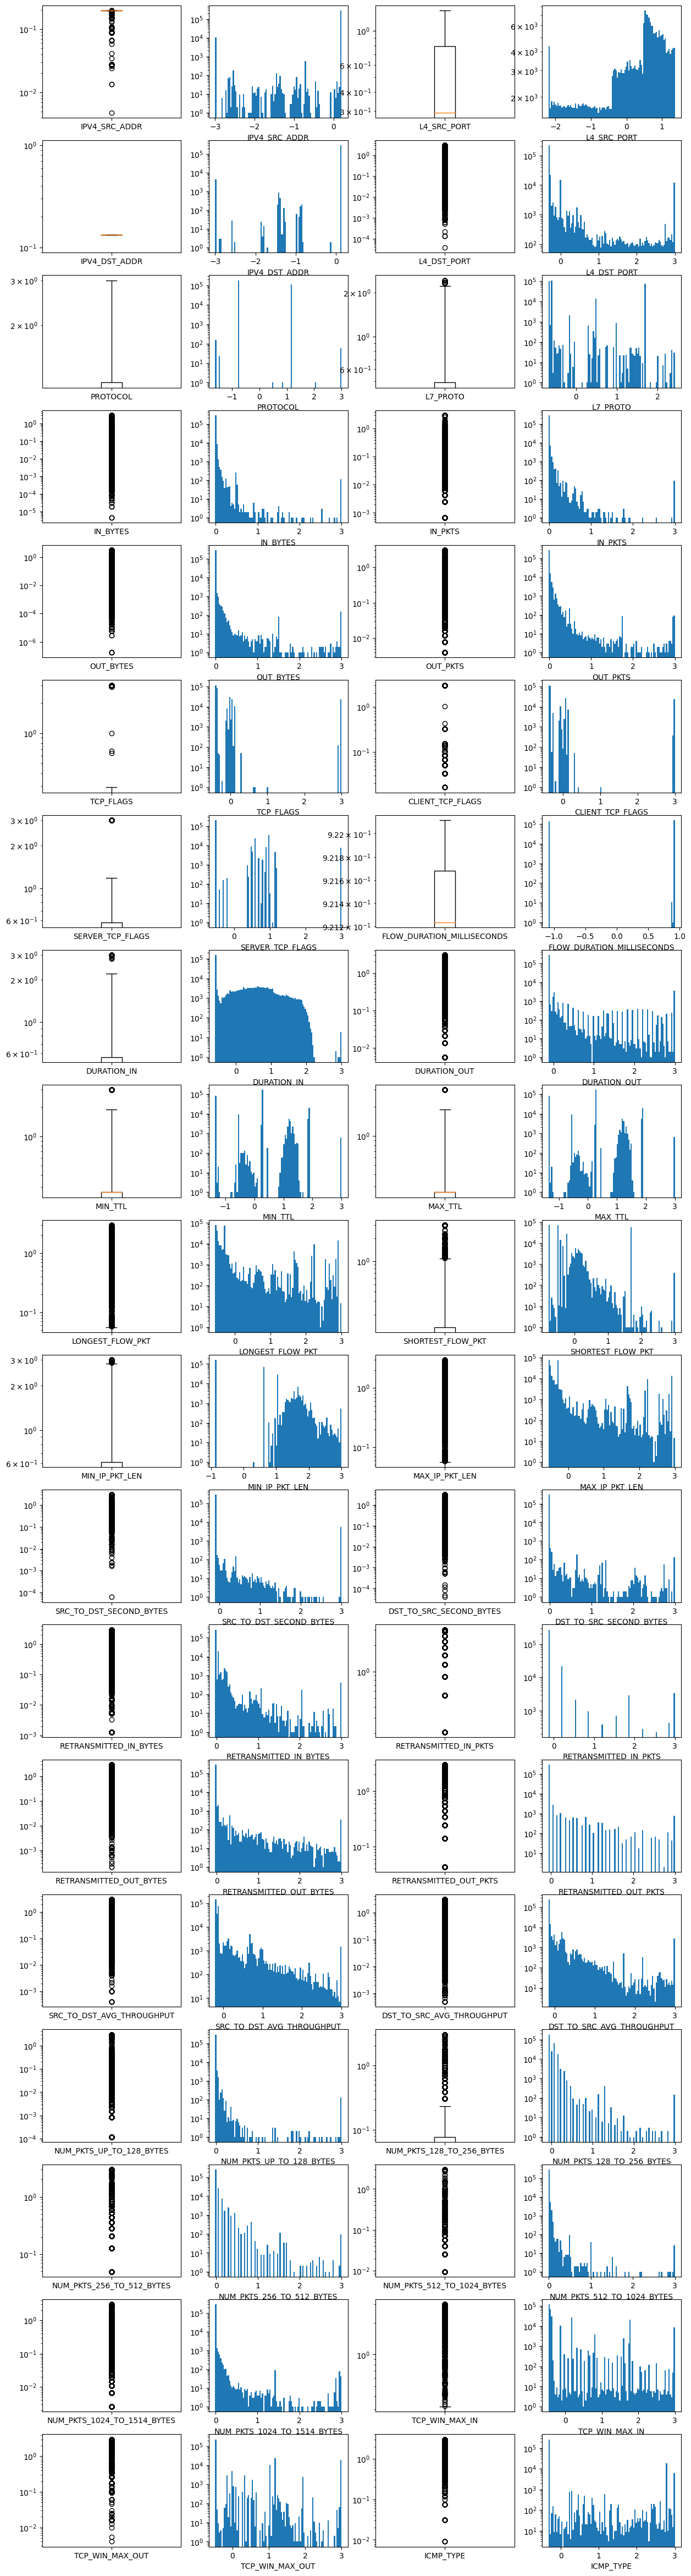

In [ ]:

plt.figure(figsize=(15,60))
k = 1
for col in cols:
  plt.subplot(19, 4, k) # 3행 3열의 9개의 그래프 중 (i+1)번째로 state 이동
  plt.boxplot([X[col]])
  plt.yscale('log')
  plt.xticks([1],[col])
  k = k+1
  plt.subplot(19, 4, k) # 3행 3열의 9개의 그래프 중 (i+1)번째로 state 이동
  plt.hist([X[col]],bins=100)
  plt.yscale('log')
  plt.xlabel(col)
  k = k+1

In [81]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle = True, random_state=64)
x_train_label, x_test_label, y_train_label, y_test_label = train_test_split(X, y_label, test_size=0.20, shuffle = True, random_state=64)

In [82]:
x_train.shape
#y_test.shape

(240000, 129)

In [83]:
Y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [85]:
y1 = tf.argmax(dummies, axis=1)
y1.numpy()

array([6, 6, 2, ..., 5, 2, 5])

In [86]:
#for stacking
from sklearn.model_selection import train_test_split
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(X, y1.numpy(), test_size=0.20, shuffle = True, random_state=64)
x_train_1, x_test_1, y_train_1_label, y_test_1_label = train_test_split(X, y_1_label, test_size=0.20, shuffle = True, random_state=64)


In [87]:
y_test_1.shape
z = y_test_1.squeeze()
k = z[0:60000]
k.shape

(60000,)

In [89]:
y_test.shape

(60000, 21)

In [88]:
X.shape[1]

129

# Model 1~4 Training

In [92]:
#model1
initializer = "glorot_uniform"
constraints = None


model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(256, input_dim=X.shape[1], kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(128, input_dim=256, kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints,activation='relu'),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Dense(128, input_dim=128, kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints,activation='relu'),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Dense(64, input_dim=128, kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints,activation='relu'),
  tf.keras.layers.Dense(y.shape[1],activation='softmax')
  ])
'''
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(64, input_dim=X.shape[1], kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints, activation='relu'),
  tf.keras.layers.Dense(128, input_dim=64, kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints,activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(128, input_dim=128, kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints,activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(64, input_dim=128, kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints,activation='relu'),
  tf.keras.layers.Dense(y.shape[1],input_dim=64, activation='softmax')
  ])
'''

'\nmodel_1 = tf.keras.Sequential([\n  tf.keras.layers.Dense(64, input_dim=X.shape[1], kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints, activation=\'relu\'),\n  tf.keras.layers.Dense(128, input_dim=64, kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints,activation=\'relu\'),\n  tf.keras.layers.Dropout(0.3),\n  tf.keras.layers.Dense(128, input_dim=128, kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints,activation=\'relu\'),\n  tf.keras.layers.Dropout(0.3),\n  tf.keras.layers.Dense(64, input_dim=128, kernel_initializer=initializer, bias_initializer="zeros", kernel_constraint=constraints,activation=\'relu\'),\n  tf.keras.layers.Dense(y.shape[1],input_dim=64, activation=\'softmax\')\n  ])\n'

In [93]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 256)               33280     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)               

In [94]:
y_train.shape

(240000, 21)

In [95]:
#model 1
model_1.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='adam')

log_dir_1 = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

monitor_1 = [
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=8, verbose=1, mode='auto',restore_best_weights=True),
             tf.keras.callbacks.TensorBoard(log_dir=log_dir_1, histogram_freq=1)
            ]
history_1  = model_1.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor_1],verbose=2, batch_size=1024, epochs=100)
#history_1  = model_1.fit(x_train,y_train,validation_split=0.2, callbacks=[monitor_1],verbose=2, batch_size=1024, epochs=100)


Epoch 1/100
235/235 - 5s - loss: 0.4687 - accuracy: 0.8632 - val_loss: 0.2061 - val_accuracy: 0.9323 - 5s/epoch - 22ms/step
Epoch 2/100
235/235 - 6s - loss: 0.2178 - accuracy: 0.9298 - val_loss: 0.1693 - val_accuracy: 0.9459 - 6s/epoch - 24ms/step
Epoch 3/100
235/235 - 4s - loss: 0.1834 - accuracy: 0.9426 - val_loss: 0.1380 - val_accuracy: 0.9595 - 4s/epoch - 16ms/step
Epoch 4/100
235/235 - 4s - loss: 0.1548 - accuracy: 0.9548 - val_loss: 0.1174 - val_accuracy: 0.9672 - 4s/epoch - 15ms/step
Epoch 5/100
235/235 - 5s - loss: 0.1371 - accuracy: 0.9617 - val_loss: 0.1103 - val_accuracy: 0.9700 - 5s/epoch - 20ms/step
Epoch 6/100
235/235 - 4s - loss: 0.1262 - accuracy: 0.9651 - val_loss: 0.1056 - val_accuracy: 0.9716 - 4s/epoch - 16ms/step
Epoch 7/100
235/235 - 4s - loss: 0.1192 - accuracy: 0.9671 - val_loss: 0.1027 - val_accuracy: 0.9728 - 4s/epoch - 15ms/step
Epoch 8/100
235/235 - 5s - loss: 0.1148 - accuracy: 0.9683 - val_loss: 0.0972 - val_accuracy: 0.9744 - 5s/epoch - 20ms/step
Epoch 9/

In [96]:
#Saving the second model
colab_path = "gdrive/My Drive/Colab Notebooks/Network/models/"
model_1.save(colab_path + 'model1.h5')

In [ ]:
#clear previous log files
!rm -rf /logs/

In [ ]:
#%load_ext tensorboard
%tensorboard --logdir logs

In [97]:
#Training  model 2  with different structure
model_2 = tf.keras.Sequential([
      tf.keras.layers.Dense(64, input_dim=X.shape[1], kernel_initializer=initializer, activation='relu'),
      tf.keras.layers.Dense(128, input_dim=64, kernel_initializer=initializer, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(256, input_dim=128, kernel_initializer=initializer, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(128, input_dim=256, kernel_initializer=initializer, activation='relu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(y.shape[1],activation='softmax')
      ])

In [98]:
#from tensorflow.keras.callbacks import EarlyStopping

model_2.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='adam')

log_dir_2 = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

monitor_2 = [
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=8, verbose=1, mode='auto',restore_best_weights=True),
             tf.keras.callbacks.TensorBoard(log_dir=log_dir_2, histogram_freq=1)
            ]
history_2  = model_2.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor_2],verbose=2, batch_size=512, epochs=100)


Epoch 1/100
469/469 - 6s - loss: 0.3643 - accuracy: 0.8885 - val_loss: 0.1859 - val_accuracy: 0.9408 - 6s/epoch - 13ms/step
Epoch 2/100
469/469 - 4s - loss: 0.1826 - accuracy: 0.9457 - val_loss: 0.1466 - val_accuracy: 0.9576 - 4s/epoch - 9ms/step
Epoch 3/100
469/469 - 4s - loss: 0.1473 - accuracy: 0.9594 - val_loss: 0.1224 - val_accuracy: 0.9657 - 4s/epoch - 9ms/step
Epoch 4/100
469/469 - 5s - loss: 0.1302 - accuracy: 0.9643 - val_loss: 0.1170 - val_accuracy: 0.9678 - 5s/epoch - 11ms/step
Epoch 5/100
469/469 - 4s - loss: 0.1218 - accuracy: 0.9668 - val_loss: 0.1071 - val_accuracy: 0.9711 - 4s/epoch - 9ms/step
Epoch 6/100
469/469 - 4s - loss: 0.1153 - accuracy: 0.9688 - val_loss: 0.1031 - val_accuracy: 0.9722 - 4s/epoch - 9ms/step
Epoch 7/100
469/469 - 5s - loss: 0.1102 - accuracy: 0.9701 - val_loss: 0.1007 - val_accuracy: 0.9729 - 5s/epoch - 11ms/step
Epoch 8/100
469/469 - 4s - loss: 0.1064 - accuracy: 0.9711 - val_loss: 0.0962 - val_accuracy: 0.9746 - 4s/epoch - 9ms/step
Epoch 9/100
4

In [99]:
#Saving the second model
colab_path = "gdrive/My Drive/Colab Notebooks/Network/models/"
model_2.save(colab_path + 'model2.h5')

In [100]:
#3 rd model for stack
model_3 = tf.keras.Sequential([
      tf.keras.layers.Dense(64, input_dim=X.shape[1], kernel_initializer=initializer, activation='relu'),
      tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(128, input_dim=X.shape[1], kernel_initializer=initializer, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(128, input_dim=X.shape[1], kernel_initializer=initializer, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(256, input_dim=X.shape[1], kernel_initializer=initializer, activation='relu'),
      tf.keras.layers.Dense(y.shape[1],activation='softmax')
      ])

In [101]:

model_3.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='adam')

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

monitor_3 = [
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=16, verbose=1, mode='auto',restore_best_weights=True),
             tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
            ]
history_3  = model_3.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor_3],verbose=2, batch_size=512, epochs=100)

Epoch 1/100
469/469 - 5s - loss: 0.4140 - accuracy: 0.8709 - val_loss: 0.1978 - val_accuracy: 0.9349 - 5s/epoch - 12ms/step
Epoch 2/100
469/469 - 4s - loss: 0.2111 - accuracy: 0.9340 - val_loss: 0.1558 - val_accuracy: 0.9509 - 4s/epoch - 8ms/step
Epoch 3/100
469/469 - 4s - loss: 0.1723 - accuracy: 0.9489 - val_loss: 0.1280 - val_accuracy: 0.9639 - 4s/epoch - 8ms/step
Epoch 4/100
469/469 - 5s - loss: 0.1464 - accuracy: 0.9591 - val_loss: 0.1167 - val_accuracy: 0.9680 - 5s/epoch - 11ms/step
Epoch 5/100
469/469 - 4s - loss: 0.1333 - accuracy: 0.9629 - val_loss: 0.1095 - val_accuracy: 0.9698 - 4s/epoch - 8ms/step
Epoch 6/100
469/469 - 4s - loss: 0.1256 - accuracy: 0.9654 - val_loss: 0.1094 - val_accuracy: 0.9702 - 4s/epoch - 8ms/step
Epoch 7/100
469/469 - 4s - loss: 0.1210 - accuracy: 0.9664 - val_loss: 0.1038 - val_accuracy: 0.9718 - 4s/epoch - 10ms/step
Epoch 8/100
469/469 - 4s - loss: 0.1165 - accuracy: 0.9678 - val_loss: 0.0988 - val_accuracy: 0.9732 - 4s/epoch - 8ms/step
Epoch 9/100
4

In [ ]:
#%load_ext tensorboard
%tensorboard --logdir logs

In [102]:
#Saving the second model
#Saving the second model
colab_path = "gdrive/My Drive/Colab Notebooks/Network/models/"
model_3.save(colab_path + 'model3.h5')

In [103]:
#4 rd model for stack
model_4 = tf.keras.Sequential([
      tf.keras.layers.Dense(128, input_dim=X.shape[1], kernel_initializer=initializer, activation='relu'),
      tf.keras.layers.Dense(64, input_dim=X.shape[1], kernel_initializer=initializer, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(32, input_dim=X.shape[1], kernel_initializer=initializer, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(128, input_dim=X.shape[1], kernel_initializer=initializer, activation='relu'),
      tf.keras.layers.Dense(y.shape[1],activation='softmax')
      ])

In [104]:
 model_4.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='adam')

 log_dir_4 = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

 monitor_4 = [
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=16, verbose=1, mode='auto',restore_best_weights=True),
             tf.keras.callbacks.TensorBoard(log_dir=log_dir_4, histogram_freq=1)
            ]
 history_4  = model_4.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor_4],verbose=2, batch_size=512, epochs=100)

Epoch 1/100
469/469 - 3s - loss: 0.4477 - accuracy: 0.8686 - val_loss: 0.1999 - val_accuracy: 0.9373 - 3s/epoch - 7ms/step
Epoch 2/100
469/469 - 4s - loss: 0.2086 - accuracy: 0.9378 - val_loss: 0.1431 - val_accuracy: 0.9602 - 4s/epoch - 8ms/step
Epoch 3/100
469/469 - 3s - loss: 0.1640 - accuracy: 0.9554 - val_loss: 0.1250 - val_accuracy: 0.9662 - 3s/epoch - 5ms/step
Epoch 4/100
469/469 - 4s - loss: 0.1426 - accuracy: 0.9622 - val_loss: 0.1157 - val_accuracy: 0.9693 - 4s/epoch - 9ms/step
Epoch 5/100
469/469 - 2s - loss: 0.1323 - accuracy: 0.9651 - val_loss: 0.1113 - val_accuracy: 0.9706 - 2s/epoch - 5ms/step
Epoch 6/100
469/469 - 2s - loss: 0.1261 - accuracy: 0.9664 - val_loss: 0.1100 - val_accuracy: 0.9715 - 2s/epoch - 5ms/step
Epoch 7/100
469/469 - 2s - loss: 0.1201 - accuracy: 0.9680 - val_loss: 0.1101 - val_accuracy: 0.9718 - 2s/epoch - 5ms/step
Epoch 8/100
469/469 - 2s - loss: 0.1164 - accuracy: 0.9689 - val_loss: 0.1037 - val_accuracy: 0.9733 - 2s/epoch - 5ms/step
Epoch 9/100
469/

In [111]:
#Saving the second model
colab_path = "gdrive/My Drive/Colab Notebooks/Network/models/"
model_4.save(colab_path + 'model4.h5')

#Model 55

In [105]:
#4 rd model for stack
model_55 = tf.keras.Sequential([
      tf.keras.layers.Dense(64, input_dim=X.shape[1], kernel_initializer=initializer, activation='relu'),
      tf.keras.layers.Dense(128, input_dim=X.shape[1], kernel_initializer=initializer, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(128, input_dim=X.shape[1], kernel_initializer=initializer, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(64, input_dim=X.shape[1], kernel_initializer=initializer, activation='relu'),
      tf.keras.layers.Dense(y_label.shape[1],activation='softmax')
      ])

In [106]:
y_train_label.shape

(240000, 2)

In [107]:
 model_55.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer='adam')

 log_dir_55 = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

 monitor_55 = [
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=16, verbose=1, mode='auto',restore_best_weights=True),
             tf.keras.callbacks.TensorBoard(log_dir=log_dir_55, histogram_freq=1)
            ]
 history_55  = model_55.fit(x_train_label,y_train_label,validation_data=(x_test_label,y_test_label), callbacks=[monitor_55],verbose=2, batch_size=512, epochs=100)

Epoch 1/100
469/469 - 4s - loss: 0.1368 - accuracy: 0.9427 - val_loss: 0.0826 - val_accuracy: 0.9691 - 4s/epoch - 8ms/step
Epoch 2/100
469/469 - 3s - loss: 0.0716 - accuracy: 0.9750 - val_loss: 0.0473 - val_accuracy: 0.9849 - 3s/epoch - 6ms/step
Epoch 3/100
469/469 - 3s - loss: 0.0466 - accuracy: 0.9857 - val_loss: 0.0382 - val_accuracy: 0.9890 - 3s/epoch - 6ms/step
Epoch 4/100
469/469 - 3s - loss: 0.0396 - accuracy: 0.9882 - val_loss: 0.0370 - val_accuracy: 0.9895 - 3s/epoch - 7ms/step
Epoch 5/100
469/469 - 3s - loss: 0.0363 - accuracy: 0.9893 - val_loss: 0.0338 - val_accuracy: 0.9906 - 3s/epoch - 6ms/step
Epoch 6/100
469/469 - 3s - loss: 0.0339 - accuracy: 0.9900 - val_loss: 0.0338 - val_accuracy: 0.9900 - 3s/epoch - 6ms/step
Epoch 7/100
469/469 - 3s - loss: 0.0323 - accuracy: 0.9906 - val_loss: 0.0352 - val_accuracy: 0.9899 - 3s/epoch - 6ms/step
Epoch 8/100
469/469 - 3s - loss: 0.0311 - accuracy: 0.9908 - val_loss: 0.0319 - val_accuracy: 0.9912 - 3s/epoch - 7ms/step
Epoch 9/100
469/

In [113]:
#Saving the second model
colab_path = "gdrive/My Drive/Colab Notebooks/Network/models/"
model_55.save(colab_path + 'model5.h5')

##Confusion Matrix

In [114]:
y_test_label

array([[0, 1],
       [1, 0],
       [0, 1],
       ...,
       [0, 1],
       [1, 0],
       [0, 1]], dtype=uint8)

In [115]:
# make a prediction with a stacked model
#neural
def predict_model55(model, inputX):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# make prediction
	return model.predict(X, verbose=2)

1875/1875 [==============================] - 3s 1ms/step
Stacked Test Accuracy: 0.9920


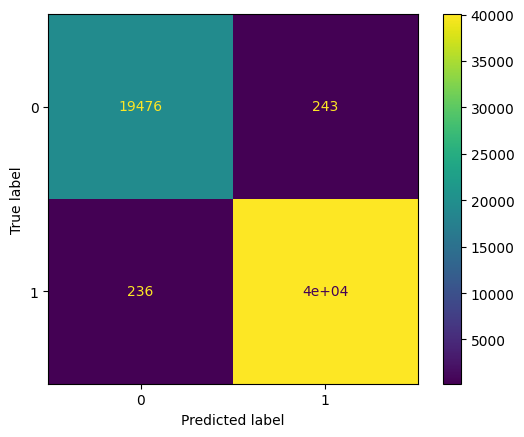

In [116]:
# 테스트 데이터에 대해 predict 수행
# 모델 성능 - confusion matrix
from sklearn.metrics import accuracy_score
import numpy as np
# make predictions and evaluate
#neural
yhat =  model_55.predict(x_test)
yhat_val = tf.argmax(yhat, axis=1)
acc = accuracy_score(y_test_1_label, yhat_val)
print('Stacked Test Accuracy: %.4f' % acc)

conf_mat = confusion_matrix(y_true=y_test_1_label, y_pred=yhat_val)
conf_mat

disp = ConfusionMatrixDisplay(conf_mat)
#disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()

In [ ]:
#Saving the second model
#Saving the second model
colab_path = "gdrive/My Drive/Colab Notebooks/Network/models/"
model_4.save(colab_path + 'model4.h5')

### 앙상블 모델
https://abstractask.tistory.com/105

In [108]:
# load models from file
# for both logistic and nueral
def load_all_models(n_models):
	all_models = list()

	for i in range(n_models):
		# define filename for this ensemble
		colab_path = "gdrive/My Drive/Colab Notebooks/Network/models/"
		#model_4.save(colab_path + 'model4.h5')
		filename = colab_path + 'model' + str(i + 1) + '.h5'
		# load model from file
		model = load_model(filename,custom_objects=None)
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models

In [109]:
# define stacked model from multiple member input models
#neural

def define_stacked_model(members):
	# update all layers in all models to not be trainable
	for i in range(len(members)):
		model = members[i]
		for layer in model.layers:
			# make not trainable
			layer.trainable = False
			# rename to avoid 'unique layer name' issue
			layer._name = 'ensemble_' + str(i + 1) + '_' + layer.name


	# define multi-headed input
	ensemble_visible = [model.input for model in members]
	# concatenate merge output from each model
	ensemble_outputs = [model.output for model in members]
	merge = concatenate(ensemble_outputs)
	hidden = Dense(64, activation='relu',name="dense_a")(merge)
	output = Dense(21, activation='softmax',name="dense_b")(hidden)
	model = Model(inputs=ensemble_visible, outputs=output)
	# plot graph of ensemble
	plot_model(model, show_shapes=True, to_file='model_graph.png')
	# compile
	model.summary()
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [110]:
colab_path = "gdrive/My Drive/Colab Notebooks/Network/models/"
log_dir = colab_path + "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [118]:
monitor_6= [
             tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
            ]

In [119]:
# fit a stacked model
#neural
def fit_stacked_model(model, inputX, inputy):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# encode output data
	inputy_enc = to_categorical(inputy)
	# fit model
	history_6=model.fit(X, inputy_enc, epochs=32, verbose=2,callbacks=[monitor_6])
	#history_6=model.fit(X, inputy, epochs=32, verbose=2,callbacks=[monitor_6])

In [120]:
# make a prediction with a stacked model
#neural
def predict_stacked_model(model, inputX):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# make prediction
	return model.predict(X, verbose=2)

In [123]:
# load all models
#neural
from keras.models import load_model
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))

>loaded gdrive/My Drive/Colab Notebooks/Network/models/model1.h5
>loaded gdrive/My Drive/Colab Notebooks/Network/models/model2.h5
>loaded gdrive/My Drive/Colab Notebooks/Network/models/model3.h5
>loaded gdrive/My Drive/Colab Notebooks/Network/models/model4.h5
>loaded gdrive/My Drive/Colab Notebooks/Network/models/model5.h5
Loaded 5 models


In [124]:
# define ensemble model
import matplotlib.pyplot as plt
#from keras.utils import plot_model
#neural
#from keras.layers.merge import concatenate
from keras.layers import concatenate
from keras.layers import Dense
from keras.models import Model
from tensorflow.keras.utils import plot_model

stacked_model = define_stacked_model(members)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 dense_10_input (InputLayer)    [(None, 129)]        0           []                               
                                                                                                  
 dense_15_input (InputLayer)    [(None, 129)]        0           []                               
                                                                                                  
 dense_20_input (InputLayer)    [(None, 129)]        0           []                               
                                                                                                  
 ensemble_1_dense_10 (Dense)    (None, 256)          33280       ['dense_10_input[0][0]']         
                                                                                              

In [125]:
y_test.shape
print(y_test_1.shape)

(60000,)


In [126]:
from keras.utils import to_categorical
inputy_enc = to_categorical(y_test_1)
print(y_test_1.shape)
print(inputy_enc.shape)
y_test_1

(60000,)
(60000, 21)


array([6, 2, 5, ..., 6, 2, 5])

In [127]:
inputy_enc

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [129]:
from keras.utils import to_categorical
# fit stacked model on test dataset
#neural
fit_stacked_model(stacked_model, x_test_1, y_test_1)

Epoch 1/32
1875/1875 - 5s - loss: 0.0796 - accuracy: 0.9792 - 5s/epoch - 2ms/step
Epoch 2/32
1875/1875 - 5s - loss: 0.0800 - accuracy: 0.9790 - 5s/epoch - 3ms/step
Epoch 3/32
1875/1875 - 4s - loss: 0.0794 - accuracy: 0.9791 - 4s/epoch - 2ms/step
Epoch 4/32
1875/1875 - 4s - loss: 0.0797 - accuracy: 0.9793 - 4s/epoch - 2ms/step
Epoch 5/32
1875/1875 - 4s - loss: 0.0799 - accuracy: 0.9793 - 4s/epoch - 2ms/step
Epoch 6/32
1875/1875 - 4s - loss: 0.0794 - accuracy: 0.9791 - 4s/epoch - 2ms/step
Epoch 7/32
1875/1875 - 4s - loss: 0.0798 - accuracy: 0.9789 - 4s/epoch - 2ms/step
Epoch 8/32
1875/1875 - 4s - loss: 0.0798 - accuracy: 0.9790 - 4s/epoch - 2ms/step
Epoch 9/32
1875/1875 - 4s - loss: 0.0799 - accuracy: 0.9790 - 4s/epoch - 2ms/step
Epoch 10/32
1875/1875 - 4s - loss: 0.0792 - accuracy: 0.9793 - 4s/epoch - 2ms/step
Epoch 11/32
1875/1875 - 4s - loss: 0.0789 - accuracy: 0.9790 - 4s/epoch - 2ms/step
Epoch 12/32
1875/1875 - 4s - loss: 0.0794 - accuracy: 0.9791 - 4s/epoch - 2ms/step
Epoch 13/32
1

# Prediction & Evaluation

In [130]:

from sklearn.metrics import accuracy_score
import numpy as np
# make predictions and evaluate
#neural
yhat = predict_stacked_model(stacked_model, x_test_1)
yhat_val = tf.argmax(yhat, axis=1)
acc = accuracy_score(y_test_1, yhat_val)
print('Stacked Test Accuracy: %.4f' % acc)

1875/1875 - 3s - 3s/epoch - 1ms/step
Stacked Test Accuracy: 0.9802


In [131]:
from sklearn.metrics import classification_report
print(classification_report(y_test_1, yhat_val))
classification_report(y_test_1, yhat_val)

              precision    recall  f1-score   support

           1       1.00      0.88      0.94        26
           2       0.99      0.99      0.99     19719
           3       1.00      1.00      1.00       104
           4       1.00      1.00      1.00       103
           5       0.99      0.99      0.99     17345
           6       0.98      0.99      0.98     14123
           7       0.65      0.85      0.73        26
           8       0.62      0.95      0.75        19
           9       1.00      0.50      0.67        12
          10       1.00      0.01      0.02        88
          11       0.97      0.95      0.96      2092
          13       1.00      1.00      1.00         1
          15       0.82      0.69      0.75       517
          16       1.00      0.33      0.50         3
          17       0.88      0.89      0.88       922
          18       1.00      0.67      0.80         3
          19       0.98      0.95      0.96      2985
          20       0.93    

'              precision    recall  f1-score   support\n\n           1       1.00      0.88      0.94        26\n           2       0.99      0.99      0.99     19719\n           3       1.00      1.00      1.00       104\n           4       1.00      1.00      1.00       103\n           5       0.99      0.99      0.99     17345\n           6       0.98      0.99      0.98     14123\n           7       0.65      0.85      0.73        26\n           8       0.62      0.95      0.75        19\n           9       1.00      0.50      0.67        12\n          10       1.00      0.01      0.02        88\n          11       0.97      0.95      0.96      2092\n          13       1.00      1.00      1.00         1\n          15       0.82      0.69      0.75       517\n          16       1.00      0.33      0.50         3\n          17       0.88      0.89      0.88       922\n          18       1.00      0.67      0.80         3\n          19       0.98      0.95      0.96      2985\n       

In [132]:
attack_labels = dummies.columns.values
attack_labels

array(['Analysis', 'Backdoor', 'Benign', 'Bot', 'Brute Force', 'DDoS',
       'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Infilteration',
       'Reconnaissance', 'Shellcode', 'Theft', 'Worms', 'injection',
       'mitm', 'password', 'ransomware', 'scanning', 'xss'], dtype=object)

1875/1875 - 2s - 2s/epoch - 1ms/step
Stacked Test Accuracy: 0.9802


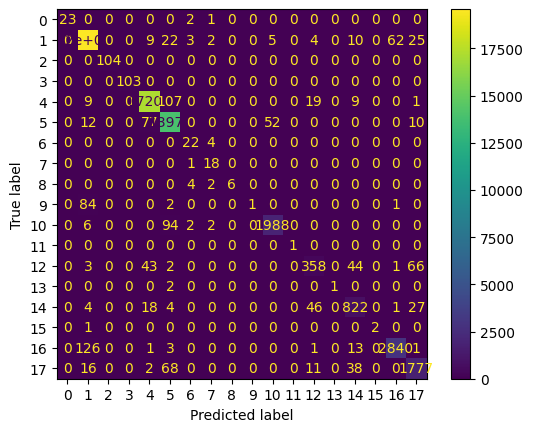

In [133]:
# 테스트 데이터에 대해 predict 수행
# 모델 성능 - confusion matrix
from sklearn.metrics import accuracy_score
import numpy as np
# make predictions and evaluate
#neural
yhat = predict_stacked_model(stacked_model, x_test_1)
yhat_val = tf.argmax(yhat, axis=1)
acc = accuracy_score(y_test_1, yhat_val)
print('Stacked Test Accuracy: %.4f' % acc)

conf_mat = confusion_matrix(y_true=y_test_1, y_pred=yhat_val)
conf_mat

disp = ConfusionMatrixDisplay(conf_mat)
#disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()

#개선 사항


##1. 논문의 구현을 재현

model 1 ~ model 4 디자인 + model 5 에 stackking



##2. 악성/정상 분류 model을 stackking에 추가

model 1 ~ model 5 디자인 + model 6을 stackking

model 1~model 4는 논문에서 제시한 model 사용
model 5는 input X 로 하고  output을 'Label'을 one-hot-encoding 값을 사용
==> 악성과 정상을 나누는 binary classification


1~5를 stacking 하여 model 6에 input으로 넣어 결과 개선 여부 관찰



##3. SRC/DST IP Address Min/Max encoding


##4. TCP Flags와 ICMP Type Code 값을 one-hot-encoding

##5. train sample이 부족한 데이터에 대한 강화 방안

# 인접 데이터 활용 학습 모델


0 group

 0   IPV4_SRC_ADDR                300000 non-null  object
 1   L4_SRC_PORT                  300000 non-null  int64  
 2   IPV4_DST_ADDR                300000 non-null  object
 3   L4_DST_PORT                  300000 non-null  int64  
 4   PROTOCOL                     300000 non-null  int64  
 5   L7_PROTO                     300000 non-null  float64
 6   IN_BYTES                     300000 non-null  int64  
 7   IN_PKTS                      300000 non-null  int64  
 8   OUT_BYTES                    300000 non-null  int64  
 9   OUT_PKTS                     300000 non-null  int64  
 10  TCP_FLAGS                    300000 non-null  int64  
 11  CLIENT_TCP_FLAGS             300000 non-null  int64  
 12  SERVER_TCP_FLAGS             300000 non-null  int64  
 13  FLOW_DURATION_MILLISECONDS   300000 non-null  int64  
 14  DURATION_IN                  300000 non-null  int64  
 15  DURATION_OUT                 300000 non-null  int64  
 16  MIN_TTL                      300000 non-null  int64  
 17  MAX_TTL                      300000 non-null  int64  
 18  LONGEST_FLOW_PKT             300000 non-null  int64  
 19  SHORTEST_FLOW_PKT            300000 non-null  int64  
 20  MIN_IP_PKT_LEN               300000 non-null  int64  
 21  MAX_IP_PKT_LEN               300000 non-null  int64  
 22  SRC_TO_DST_SECOND_BYTES      300000 non-null  float64
 23  DST_TO_SRC_SECOND_BYTES      300000 non-null  float64
 24  RETRANSMITTED_IN_BYTES       300000 non-null  int64  
 25  RETRANSMITTED_IN_PKTS        300000 non-null  int64  
 26  RETRANSMITTED_OUT_BYTES      300000 non-null  int64  
 27  RETRANSMITTED_OUT_PKTS       300000 non-null  int64  
 28  SRC_TO_DST_AVG_THROUGHPUT    300000 non-null  int64  
 29  DST_TO_SRC_AVG_THROUGHPUT    300000 non-null  int64  
 30  NUM_PKTS_UP_TO_128_BYTES     300000 non-null  int64  
 31  NUM_PKTS_128_TO_256_BYTES    300000 non-null  int64  
 32  NUM_PKTS_256_TO_512_BYTES    300000 non-null  int64  
 33  NUM_PKTS_512_TO_1024_BYTES   300000 non-null  int64  
 34  NUM_PKTS_1024_TO_1514_BYTES  300000 non-null  int64  
 35  TCP_WIN_MAX_IN               300000 non-null  int64  
 36  TCP_WIN_MAX_OUT              300000 non-null  int64  
 37  ICMP_TYPE                    300000 non-null  int64  
 38  ICMP_IPV4_TYPE               300000 non-null  int64  
 39  DNS_QUERY_ID                 300000 non-null  int64  
 40  DNS_QUERY_TYPE               300000 non-null  int64  
 41  DNS_TTL_ANSWER               300000 non-null  int64  
 42  FTP_COMMAND_RET_CODE         300000 non-null  float64
 43  Label                        300000 non-null  int64  
 44  Attack                       300000 non-null  object
 45  Dataset                      300000 non-null  object


1 group

현재 레코드 는 그대로 유지
  0   IPV4_SRC_ADDR                300000 non-null  object
 1   L4_SRC_PORT                  300000 non-null  int64  
 2   IPV4_DST_ADDR                300000 non-null  object
 3   L4_DST_PORT                  300000 non-null  int64  
 4   PROTOCOL                     300000 non-null  int64  
 5   L7_PROTO                     300000 non-null  float64
 6   IN_BYTES                     300000 non-null  int64  
 7   IN_PKTS                      300000 non-null  int64  
 8   OUT_BYTES                    300000 non-null  int64  
 9   OUT_PKTS                     300000 non-null  int64  
 10  TCP_FLAGS                    300000 non-null  int64  
 11  CLIENT_TCP_FLAGS             300000 non-null  int64  
 12  SERVER_TCP_FLAGS             300000 non-null  int64  
 13  FLOW_DURATION_MILLISECONDS   300000 non-null  int64  
 14  DURATION_IN                  300000 non-null  int64  
 15  DURATION_OUT                 300000 non-null  int64  
 16  MIN_TTL                      300000 non-null  int64  
 17  MAX_TTL                      300000 non-null  int64  
 18  LONGEST_FLOW_PKT             300000 non-null  int64  
 19  SHORTEST_FLOW_PKT            300000 non-null  int64  
 20  MIN_IP_PKT_LEN               300000 non-null  int64  
 21  MAX_IP_PKT_LEN               300000 non-null  int64  
 22  SRC_TO_DST_SECOND_BYTES      300000 non-null  float64
 23  DST_TO_SRC_SECOND_BYTES      300000 non-null  float64
 24  RETRANSMITTED_IN_BYTES       300000 non-null  int64  
 25  RETRANSMITTED_IN_PKTS        300000 non-null  int64  
 26  RETRANSMITTED_OUT_BYTES      300000 non-null  int64  
 27  RETRANSMITTED_OUT_PKTS       300000 non-null  int64  
 28  SRC_TO_DST_AVG_THROUGHPUT    300000 non-null  int64  
 29  DST_TO_SRC_AVG_THROUGHPUT    300000 non-null  int64  
 30  NUM_PKTS_UP_TO_128_BYTES     300000 non-null  int64  
 31  NUM_PKTS_128_TO_256_BYTES    300000 non-null  int64  
 32  NUM_PKTS_256_TO_512_BYTES    300000 non-null  int64  
 33  NUM_PKTS_512_TO_1024_BYTES   300000 non-null  int64  
 34  NUM_PKTS_1024_TO_1514_BYTES  300000 non-null  int64  
 35  TCP_WIN_MAX_IN               300000 non-null  int64  
 36  TCP_WIN_MAX_OUT              300000 non-null  int64  
 37  ICMP_TYPE                    300000 non-null  int64  
 38  ICMP_IPV4_TYPE               300000 non-null  int64  
 39  DNS_QUERY_ID                 300000 non-null  int64  
 40  DNS_QUERY_TYPE               300000 non-null  int64  
 41  DNS_TTL_ANSWER               300000 non-null  int64  
 42  FTP_COMMAND_RET_CODE         300000 non-null  float64

 삭제 0   IPV4_SRC_ADDR                300000 non-null  object
 43   L4_SRC_PORT_1                  300000 non-null  int64  
 44   IPV4_DST_ADDR_1                300000 non-null  object
 45   L4_DST_PORT_1                  300000 non-null  int64  
 46   PROTOCOL_1                     300000 non-null  int64  
 47   L7_PROTO_1                     300000 non-null  float64
 48   IN_BYTES_1                     300000 non-null  int64  
 7   IN_PKTS                      300000 non-null  int64  
 8   OUT_BYTES                    300000 non-null  int64  
 9   OUT_PKTS                     300000 non-null  int64  
 10  TCP_FLAGS                    300000 non-null  int64  
 11  CLIENT_TCP_FLAGS             300000 non-null  int64  
 12  SERVER_TCP_FLAGS             300000 non-null  int64  
 13  FLOW_DURATION_MILLISECONDS   300000 non-null  int64  
 14  DURATION_IN                  300000 non-null  int64  
 15  DURATION_OUT                 300000 non-null  int64  
 16  MIN_TTL                      300000 non-null  int64  
 17  MAX_TTL                      300000 non-null  int64  
 18  LONGEST_FLOW_PKT             300000 non-null  int64  
 19  SHORTEST_FLOW_PKT            300000 non-null  int64  
 20  MIN_IP_PKT_LEN               300000 non-null  int64  
 21  MAX_IP_PKT_LEN               300000 non-null  int64  
 22  SRC_TO_DST_SECOND_BYTES      300000 non-null  float64
 23  DST_TO_SRC_SECOND_BYTES      300000 non-null  float64
 24  RETRANSMITTED_IN_BYTES       300000 non-null  int64  
 25  RETRANSMITTED_IN_PKTS        300000 non-null  int64  
 26  RETRANSMITTED_OUT_BYTES      300000 non-null  int64  
 27  RETRANSMITTED_OUT_PKTS       300000 non-null  int64  
 28  SRC_TO_DST_AVG_THROUGHPUT    300000 non-null  int64  
 29  DST_TO_SRC_AVG_THROUGHPUT    300000 non-null  int64  
 30  NUM_PKTS_UP_TO_128_BYTES     300000 non-null  int64  
 31  NUM_PKTS_128_TO_256_BYTES    300000 non-null  int64  
 32  NUM_PKTS_256_TO_512_BYTES    300000 non-null  int64  
 33  NUM_PKTS_512_TO_1024_BYTES   300000 non-null  int64  
 34  NUM_PKTS_1024_TO_1514_BYTES  300000 non-null  int64  
 35  TCP_WIN_MAX_IN               300000 non-null  int64  
 36  TCP_WIN_MAX_OUT              300000 non-null  int64  
 37  ICMP_TYPE                    300000 non-null  int64  
 38  ICMP_IPV4_TYPE               300000 non-null  int64  
 39  DNS_QUERY_ID                 300000 non-null  int64  
 81  DNS_QUERY_TYPE_1               300000 non-null  int64  
 82  DNS_TTL_ANSWER_1               300000 non-null  int64  
 83  FTP_COMMAND_RET_CODE_1         300000 non-null  float64


 2 group

 삭제   L4_SRC_PORT                  300000 non-null  int64  
 84   IPV4_DST_ADDR_2                300000 non-null  object
 85   L4_DST_PORT_2                  300000 non-null  int64  
 86   PROTOCOL_2                     300000 non-null  int64  
 5   L7_PROTO                     300000 non-null  float64
 6   IN_BYTES                     300000 non-null  int64  
 7   IN_PKTS                      300000 non-null  int64  
 8   OUT_BYTES                    300000 non-null  int64  
 9   OUT_PKTS                     300000 non-null  int64  
 10  TCP_FLAGS                    300000 non-null  int64  
 11  CLIENT_TCP_FLAGS             300000 non-null  int64  
 12  SERVER_TCP_FLAGS             300000 non-null  int64  
 13  FLOW_DURATION_MILLISECONDS   300000 non-null  int64  
 14  DURATION_IN                  300000 non-null  int64  
 15  DURATION_OUT                 300000 non-null  int64  
 16  MIN_TTL                      300000 non-null  int64  
 17  MAX_TTL                      300000 non-null  int64  
 18  LONGEST_FLOW_PKT             300000 non-null  int64  
 19  SHORTEST_FLOW_PKT            300000 non-null  int64  
 20  MIN_IP_PKT_LEN               300000 non-null  int64  
 21  MAX_IP_PKT_LEN               300000 non-null  int64  
 22  SRC_TO_DST_SECOND_BYTES      300000 non-null  float64
 23  DST_TO_SRC_SECOND_BYTES      300000 non-null  float64
 24  RETRANSMITTED_IN_BYTES       300000 non-null  int64  
 25  RETRANSMITTED_IN_PKTS        300000 non-null  int64  
 26  RETRANSMITTED_OUT_BYTES      300000 non-null  int64  
 27  RETRANSMITTED_OUT_PKTS       300000 non-null  int64  
 28  SRC_TO_DST_AVG_THROUGHPUT    300000 non-null  int64  
 29  DST_TO_SRC_AVG_THROUGHPUT    300000 non-null  int64  
 30  NUM_PKTS_UP_TO_128_BYTES     300000 non-null  int64  
 31  NUM_PKTS_128_TO_256_BYTES    300000 non-null  int64  
 32  NUM_PKTS_256_TO_512_BYTES    300000 non-null  int64  
 33  NUM_PKTS_512_TO_1024_BYTES   300000 non-null  int64  
 34  NUM_PKTS_1024_TO_1514_BYTES  300000 non-null  int64  
 35  TCP_WIN_MAX_IN               300000 non-null  int64  
 36  TCP_WIN_MAX_OUT              300000 non-null  int64  
 37  ICMP_TYPE                    300000 non-null  int64  
 38  ICMP_IPV4_TYPE               300000 non-null  int64  
 39  DNS_QUERY_ID                 300000 non-null  int64  
 40  DNS_QUERY_TYPE               300000 non-null  int64  
 41  DNS_TTL_ANSWER               300000 non-null  int64  
 124  FTP_COMMAND_RET_CODE_2         300000 non-null  float64
_
0 그룹은 현재의 레코드를 유지한다.     Y는 Attack의 dummy 변환값
1 그룹은 0그룹의 Src_IP와 동일한 레코드를 과거 가장가까운 시간 레코드를 찾아 그 값을 복사한다.
만약 과거 가장 가까운 시간 레코드가 존재하지 않으면 미래의 가장 가까운 시간 레코드를 찾아 그 값을 복사한다.
만약 과거도 미래도 없으면 모든 값을 0으로 설정한다.

2 그룹은 0그룹의 Src_IP와 동일한 레코드를 과거 두번째 가까운 시간 레코드를 찾아 그 값을 복사한다.
만약 두번째 가까운 레코드가 없으면 첫번째 가까운레코드가 있는경우는
 - 미래에 가장가까운 레코드를 찾아 그 값을 복사한다.

만약 과거 가장 가까운 시간 레코드가 존재하지 않으면 미래의 두번째 가까운 시간 레코드를 찾아 그 값을 복사한다.
 만약 그 값이 존재하지 않으면 모든 값을 0으로 설정한다.


